# Todo

1. Fix time steps and time points --> refit
2. Visualize loss landscape from losses stored in results
3. Compute and compare Pearson correlation for each fitting method

1. Validate fitting approach on simpler data
2. Visualize loss landscape

# Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import pickle
import time
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import skopt
import skopt.plots
import scipy.optimize
import scipy.stats
from tqdm.auto import tqdm

In [3]:
dir_project = os.path.abspath('..')
dir_modules = os.path.join(dir_project, 'modules')
dir_scripts = os.path.join(dir_project, 'scripts')
dir_data = os.path.join(dir_project, 'data')
dir_data_aux = os.path.join(dir_project, 'data_aux')

In [4]:
sys.path.append(dir_modules)
import simulate
import stats_transcripts
import fitting
import utils_genomics

In [5]:
params = np.load(os.path.join(dir_data_aux, 'sim_spliced_fraction', 'params.npy'))
gene_length = 3640
pos_intron = np.array(
    [[ 828, 1135, 1669, 2363, 2579],
     [ 952, 1229, 2122, 2449, 3537]])
pos_exon = utils_genomics.pos_intron_to_pos_exon(pos_intron, gene_length)
time_steps = np.array([0, 10, 15, 20, 25, 30, 45, 60, 75, 90, 120, 240]) * 60 + 600

In [6]:
param_names = ['k_init', 'k_decay', 'k_splice', 'k_elong']
n_params = params.shape[1]
n_param_values = len(params)
n_introns = pos_intron.shape[1]
time_points = np.arange(time_steps[-1])
n_time_steps = time_steps[-1]
data_time = time_steps - 1
cols_introns = [f'intron{i}' for i in range(n_introns)]

# Visualize Simulated Data

Spliced fraction is not identifiable. Bond counts is identifiable.

## Spliced Fraction

In [7]:
data_sfs_mean = pd.concat((
    pd.DataFrame(
        np.load(os.path.join(dir_data_aux, 'sim_spliced_fraction', f'mean-{index}.npy')),
        columns=cols_introns).assign(param_index=index)
    for index in range(n_param_values)),
    axis=0)
data_sfs_mean['time_point'] = data_sfs_mean.index.values
data_sfs_mean.reset_index(drop=True, inplace=True)
data_sfs_mean[param_names] = data_sfs_mean['param_index'].map(lambda x: params[x]).tolist()

data_sfs_mean_fillna = pd.concat((
    pd.DataFrame(
        np.load(os.path.join(dir_data_aux, 'sim_spliced_fraction', f'mean_fillna-{index}.npy')),
        columns=cols_introns).assign(param_index=index)
    for index in range(n_param_values)),
    axis=0)
data_sfs_mean_fillna['time_point'] = data_sfs_mean_fillna.index.values
data_sfs_mean_fillna.reset_index(drop=True, inplace=True)
data_sfs_mean_fillna[param_names] = data_sfs_mean_fillna['param_index'].map(lambda x: params[x]).tolist()

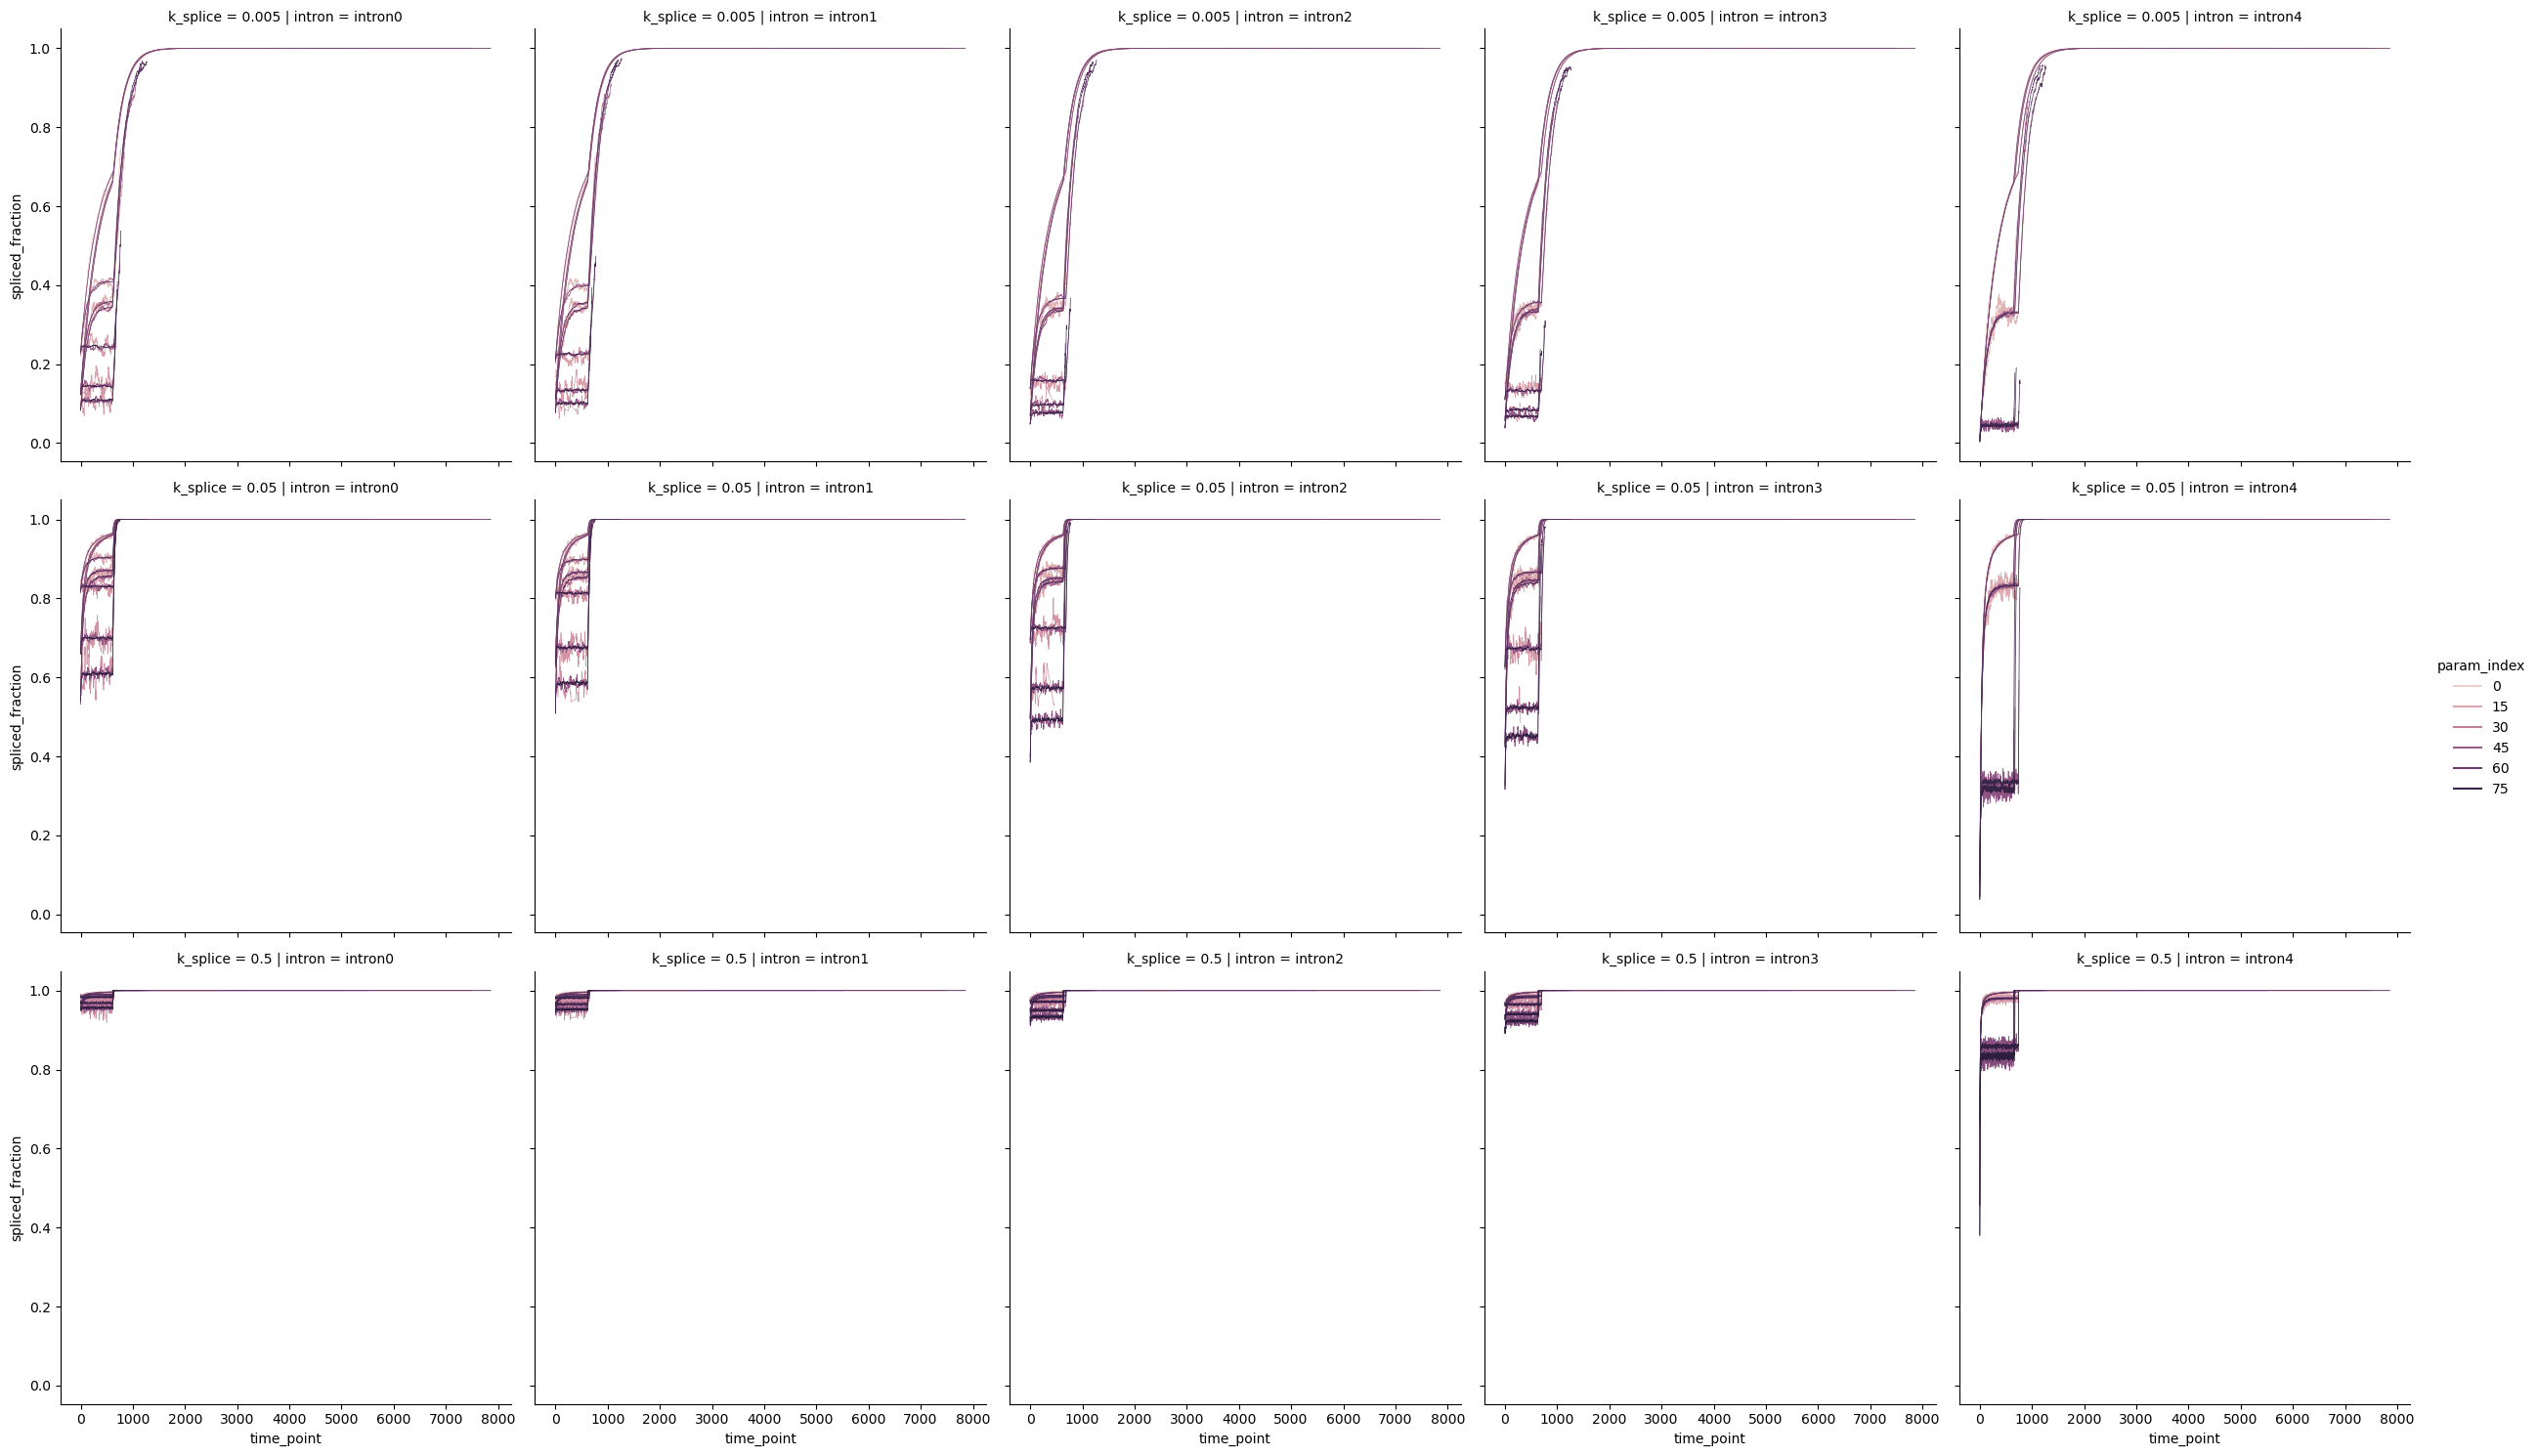

In [7]:
sns.relplot(
    kind='line',
    data=data_sfs_mean.melt(
        id_vars=['time_point', 'param_index'] + param_names,
        value_vars=cols_introns,
        var_name='intron',
        value_name='spliced_fraction'),
    x='time_point',
    y='spliced_fraction',
    hue='param_index',
    row='k_splice',
    col='intron',
    estimator=None,
    errorbar=None,
    linewidth=0.5)

Visualize a single intron at a single splice rate value: ientifiability is low

- For a given splice rate and decay rate pair, many different pair of k_init and k_elong rates can give very similar trajectories

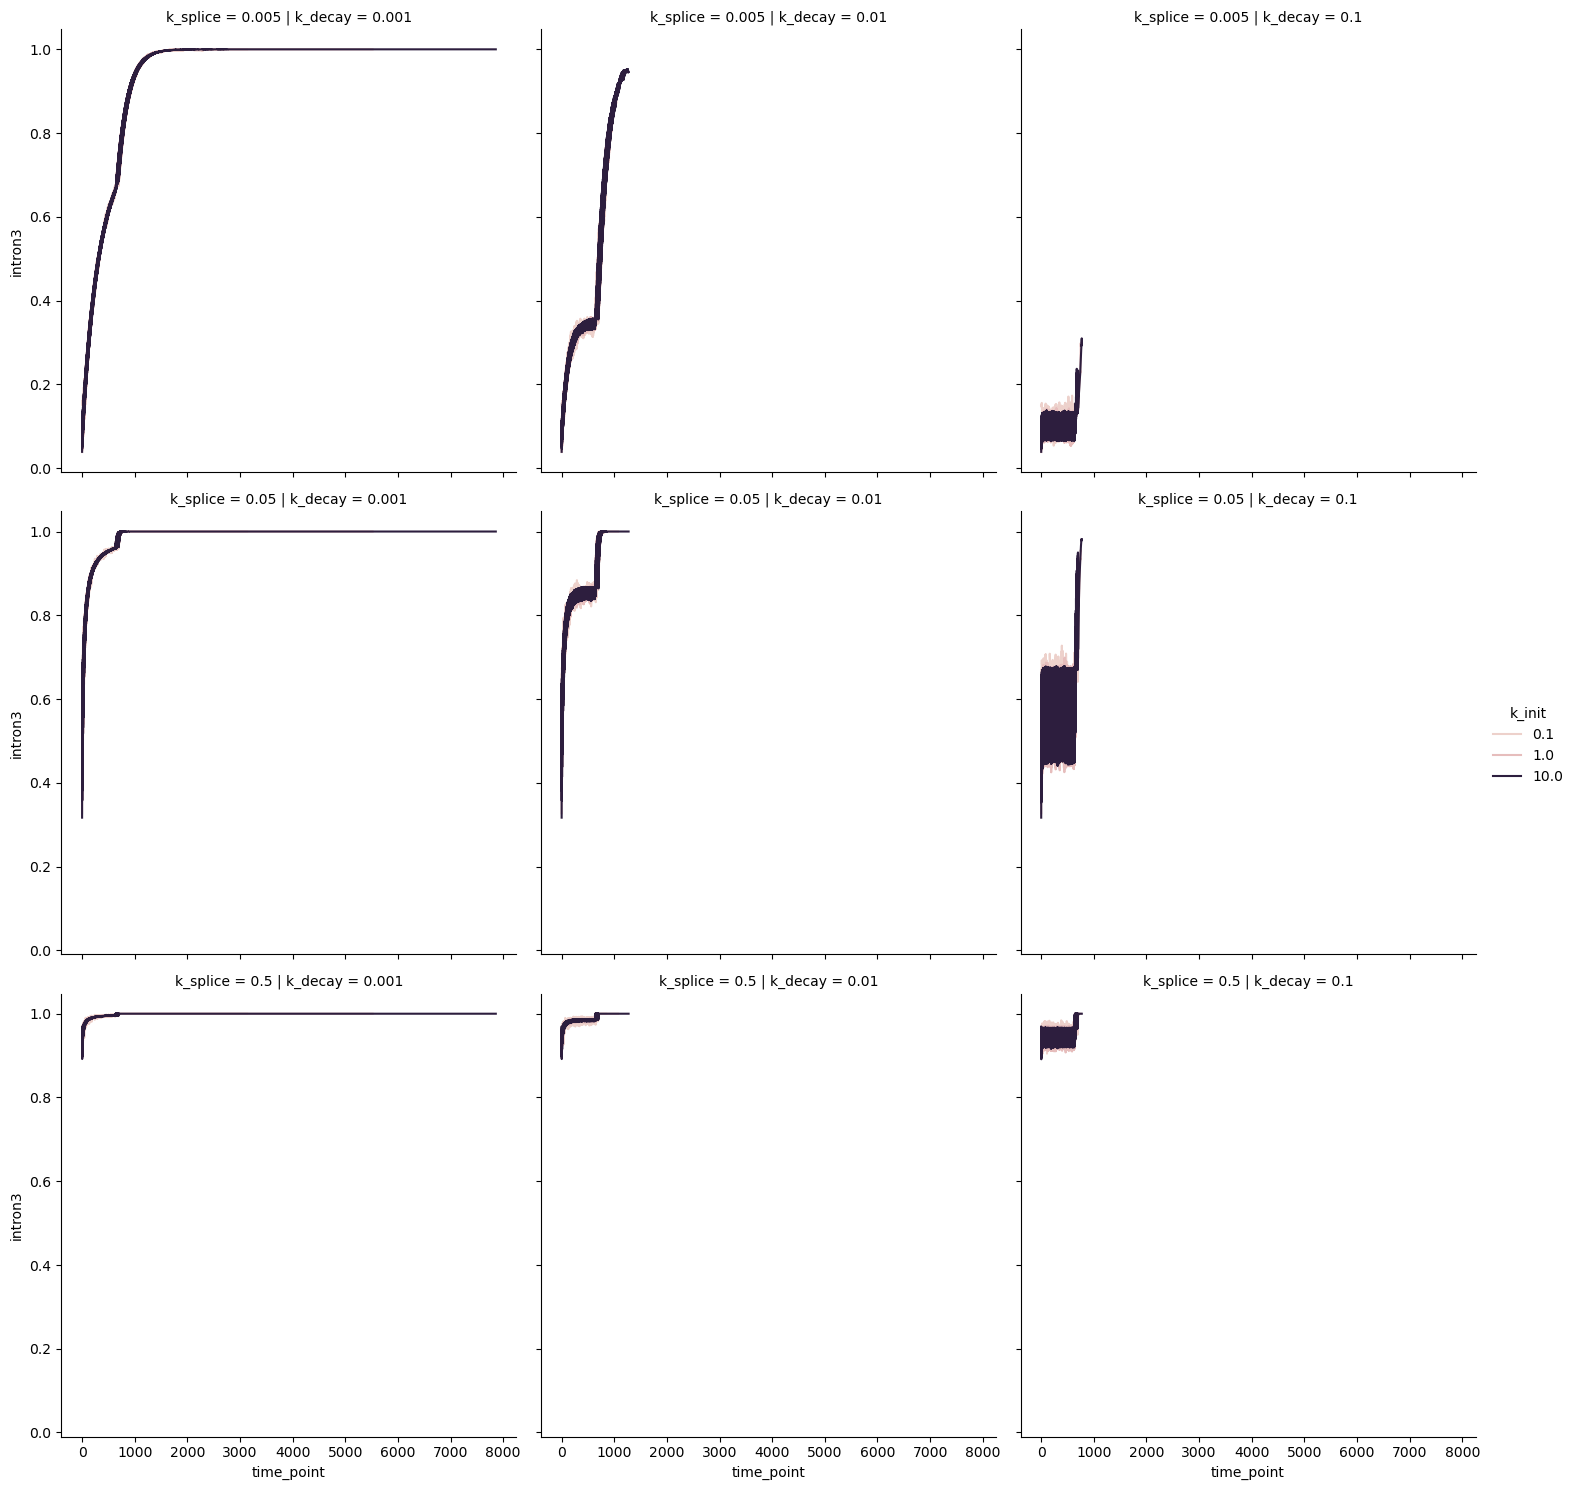

In [49]:
sns.relplot(
    kind='line',
    data=data_sfs_mean,
    x='time_point',
    y='intron3',
    hue='k_init',
    row='k_splice',
    col='k_decay',
    estimator=None,
    errorbar=None)

### Compare mean vs. mean_fillna

- mean: mean of spliced fraction over multiple simulations --> the mean value at a time point is `np.nan` if any simulation has value `np.nan` at that time point
- mean_fillna: mean of spliced fraction over multiple simulations, with `np.nan` values replaced by 1

Global comparison: mean and mean_fillna are identical except for the np.nan values

In [38]:
np.array_equal(data_sfs_mean.values[~np.isnan(data_sfs_mean)], data_sfs_mean_fillna.values[~np.isnan(data_sfs_mean)])

True

Visualize a single parameter set

In [19]:
mean0 = np.load(os.path.join(dir_data_aux, 'sim_spliced_fraction', 'mean-0.npy'))
mean_fillna0 = np.load(os.path.join(dir_data_aux, 'sim_spliced_fraction', 'mean_fillna-0.npy'))

In [20]:
time_points = np.arange(mean0.shape[0])
n_introns = mean0.shape[1]

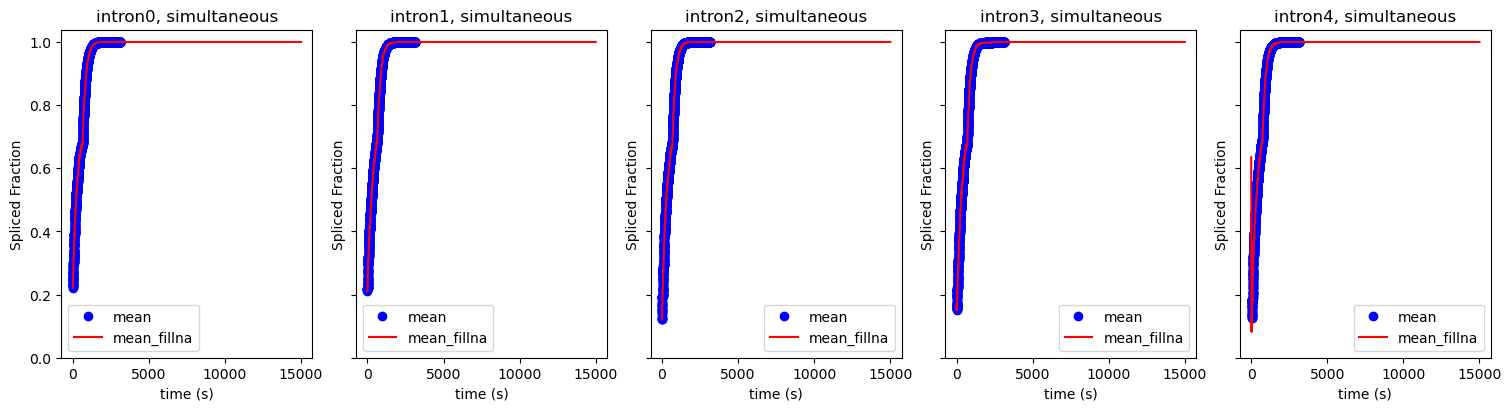

In [21]:
fig, axs = plt.subplots(1, n_introns, sharex=True, sharey='row', figsize=(15, 4), constrained_layout=True)
for i in range(n_introns):
    # mean
    axs[i].plot(time_points, mean0[:, i], 'bo', label='mean')
    # mean with NAs replaced by 1
    axs[i].plot(time_points, mean_fillna0[:, i], 'r-', label='mean_fillna')
    axs[i].set(xlabel='time (s)', ylabel='Spliced Fraction', title=f'intron{i}, simultaneous', ylim=(0, None))
    axs[i].legend()
fig.show()

Zoom into first 2000 seconds

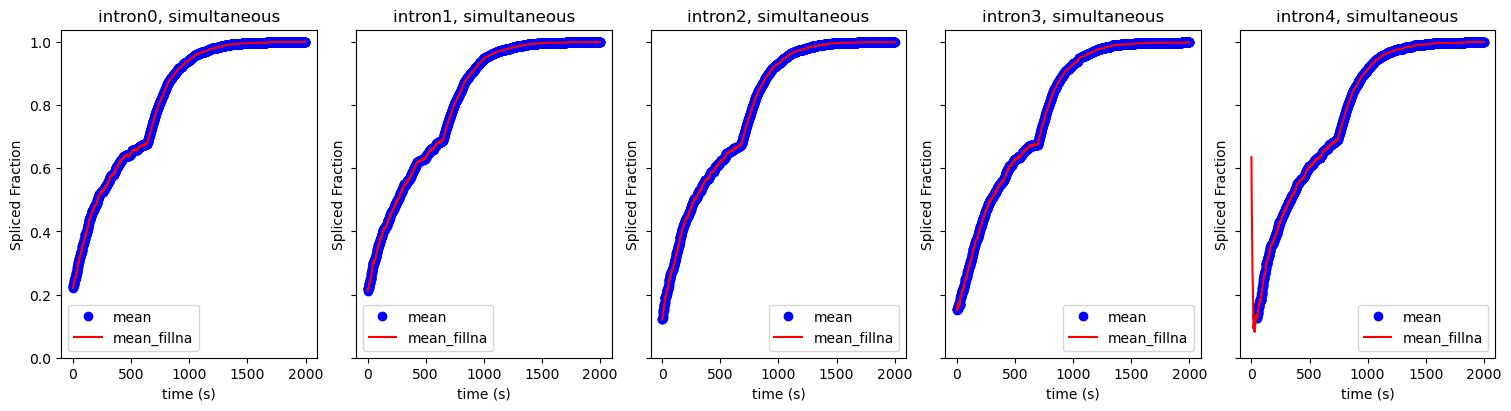

In [23]:
fig, axs = plt.subplots(1, n_introns, sharex=True, sharey='row', figsize=(15, 4), constrained_layout=True)
for i in range(n_introns):
    # mean
    axs[i].plot(time_points[:2000], mean0[:2000, i], 'bo', label='mean')
    # mean with NAs replaced by 1
    axs[i].plot(time_points[:2000], mean_fillna0[:2000, i], 'r-', label='mean_fillna')
    axs[i].set(xlabel='time (s)', ylabel='Spliced Fraction', title=f'intron{i}, simultaneous', ylim=(0, None))
    axs[i].legend()
fig.show()

## Bond Counts

In [8]:
data_bcs = pd.concat((
    pd.DataFrame(
        np.squeeze(np.vstack(np.dsplit(np.load(os.path.join(dir_data_aux, 'sim_bond_counts', f'mean-{index}.npy')), 3))),
        columns=cols_introns) \
        .assign(
            param_index=index,
            time_point=np.tile(time_points, 3),
            bond=np.repeat(['donor', 'acceptor', 'spliced'], time_steps[-1]))
    for index in range(n_param_values)),
    axis=0).reset_index(drop=True)
data_bcs[param_names] = data_bcs['param_index'].map(lambda x: params[x]).tolist()

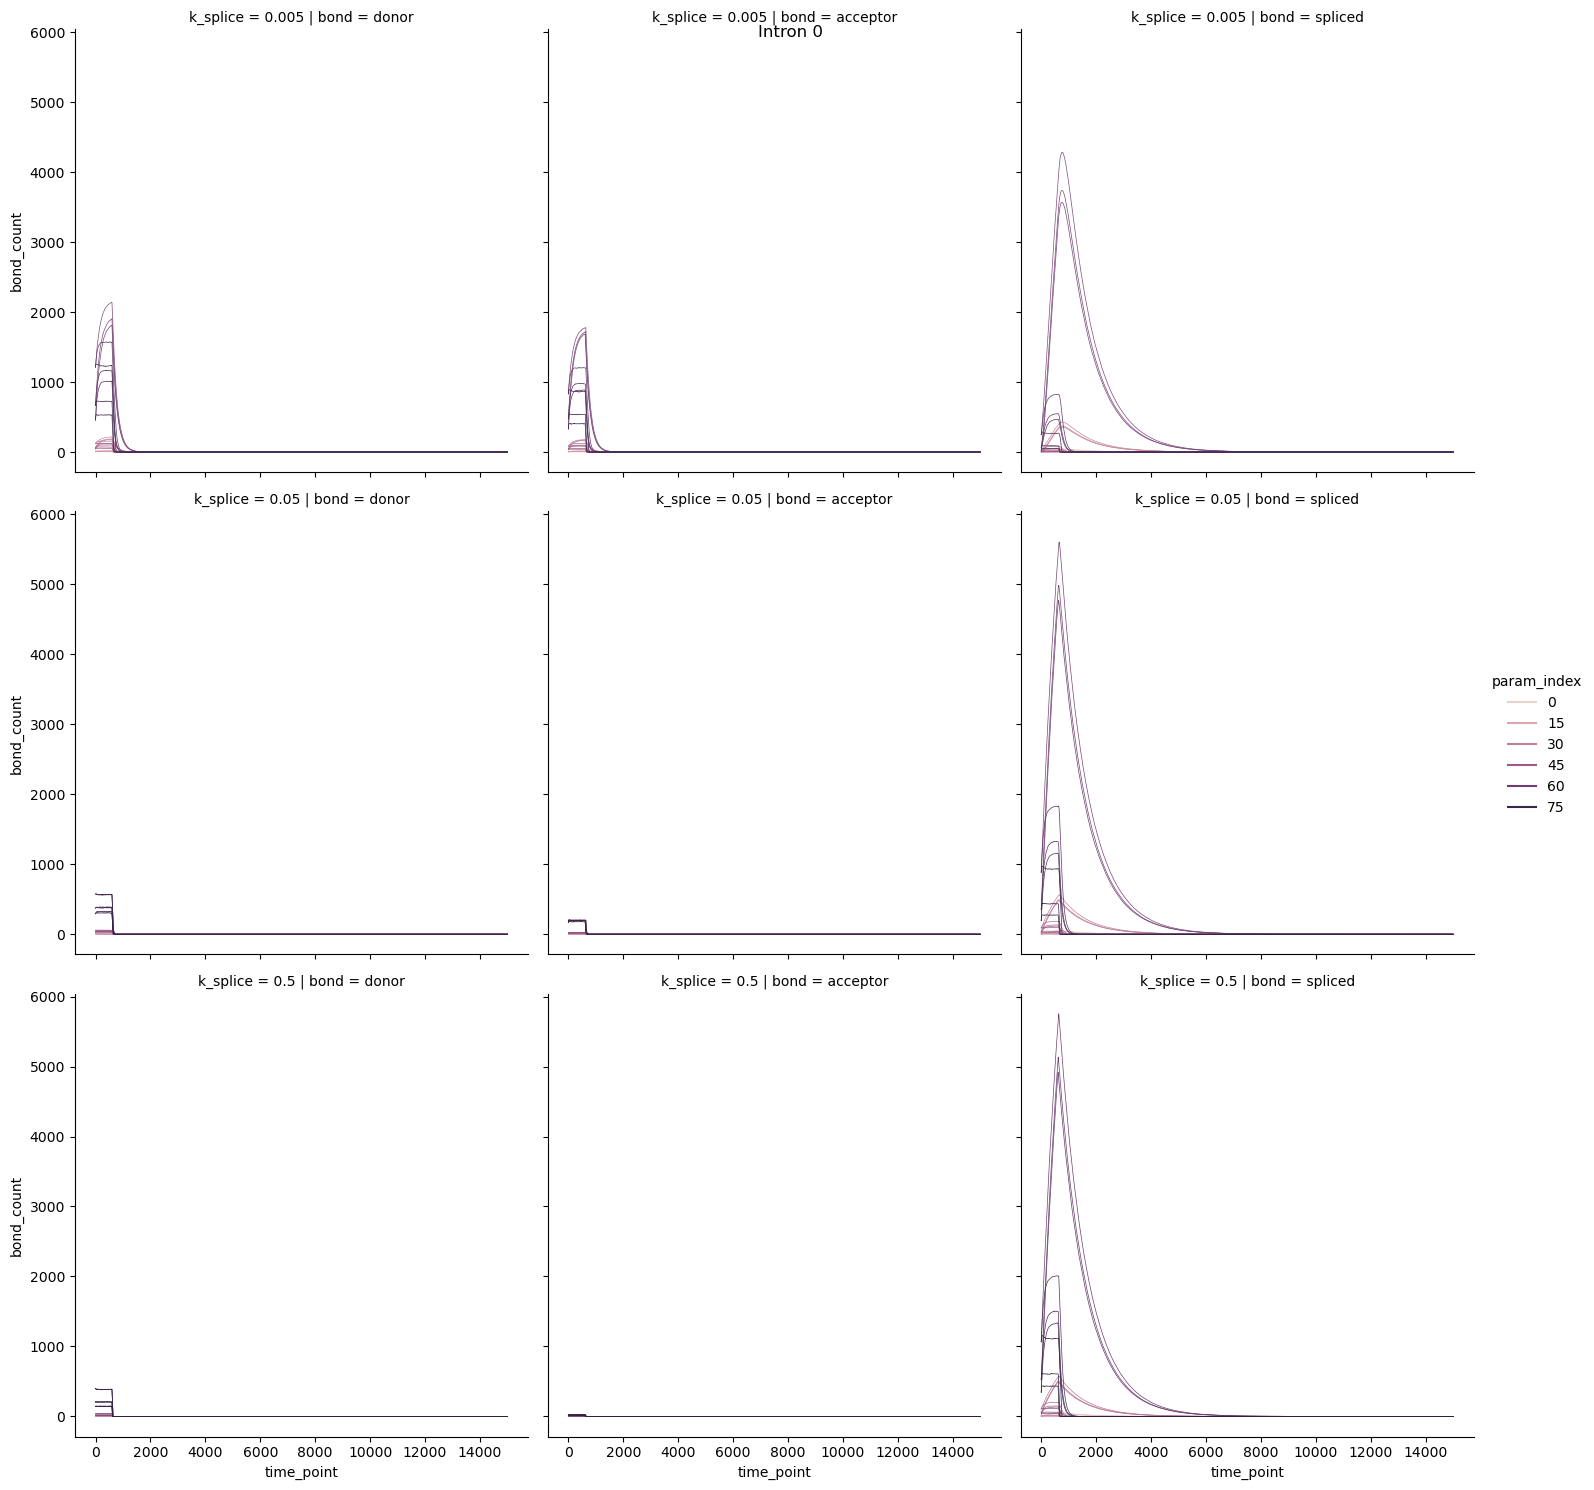

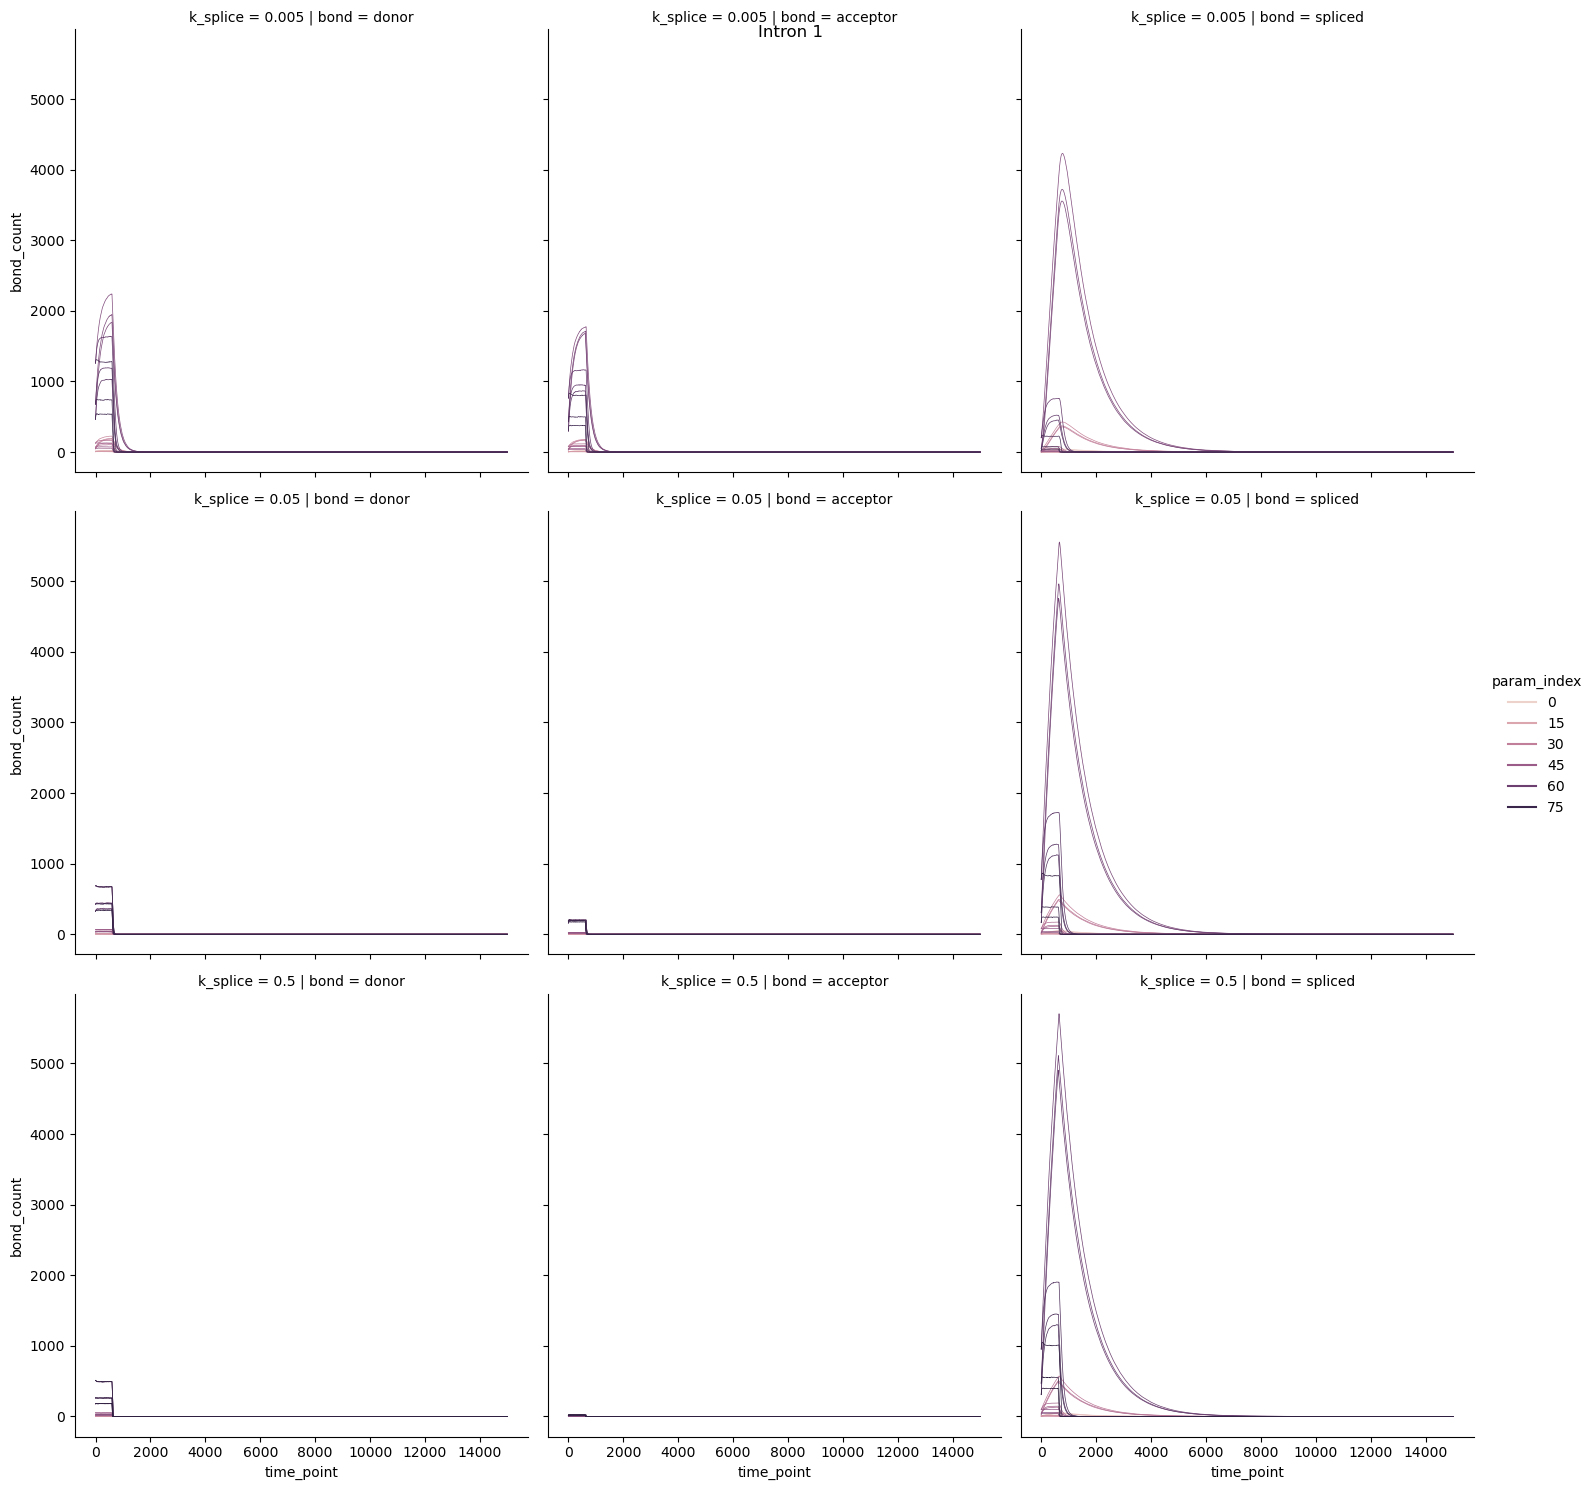

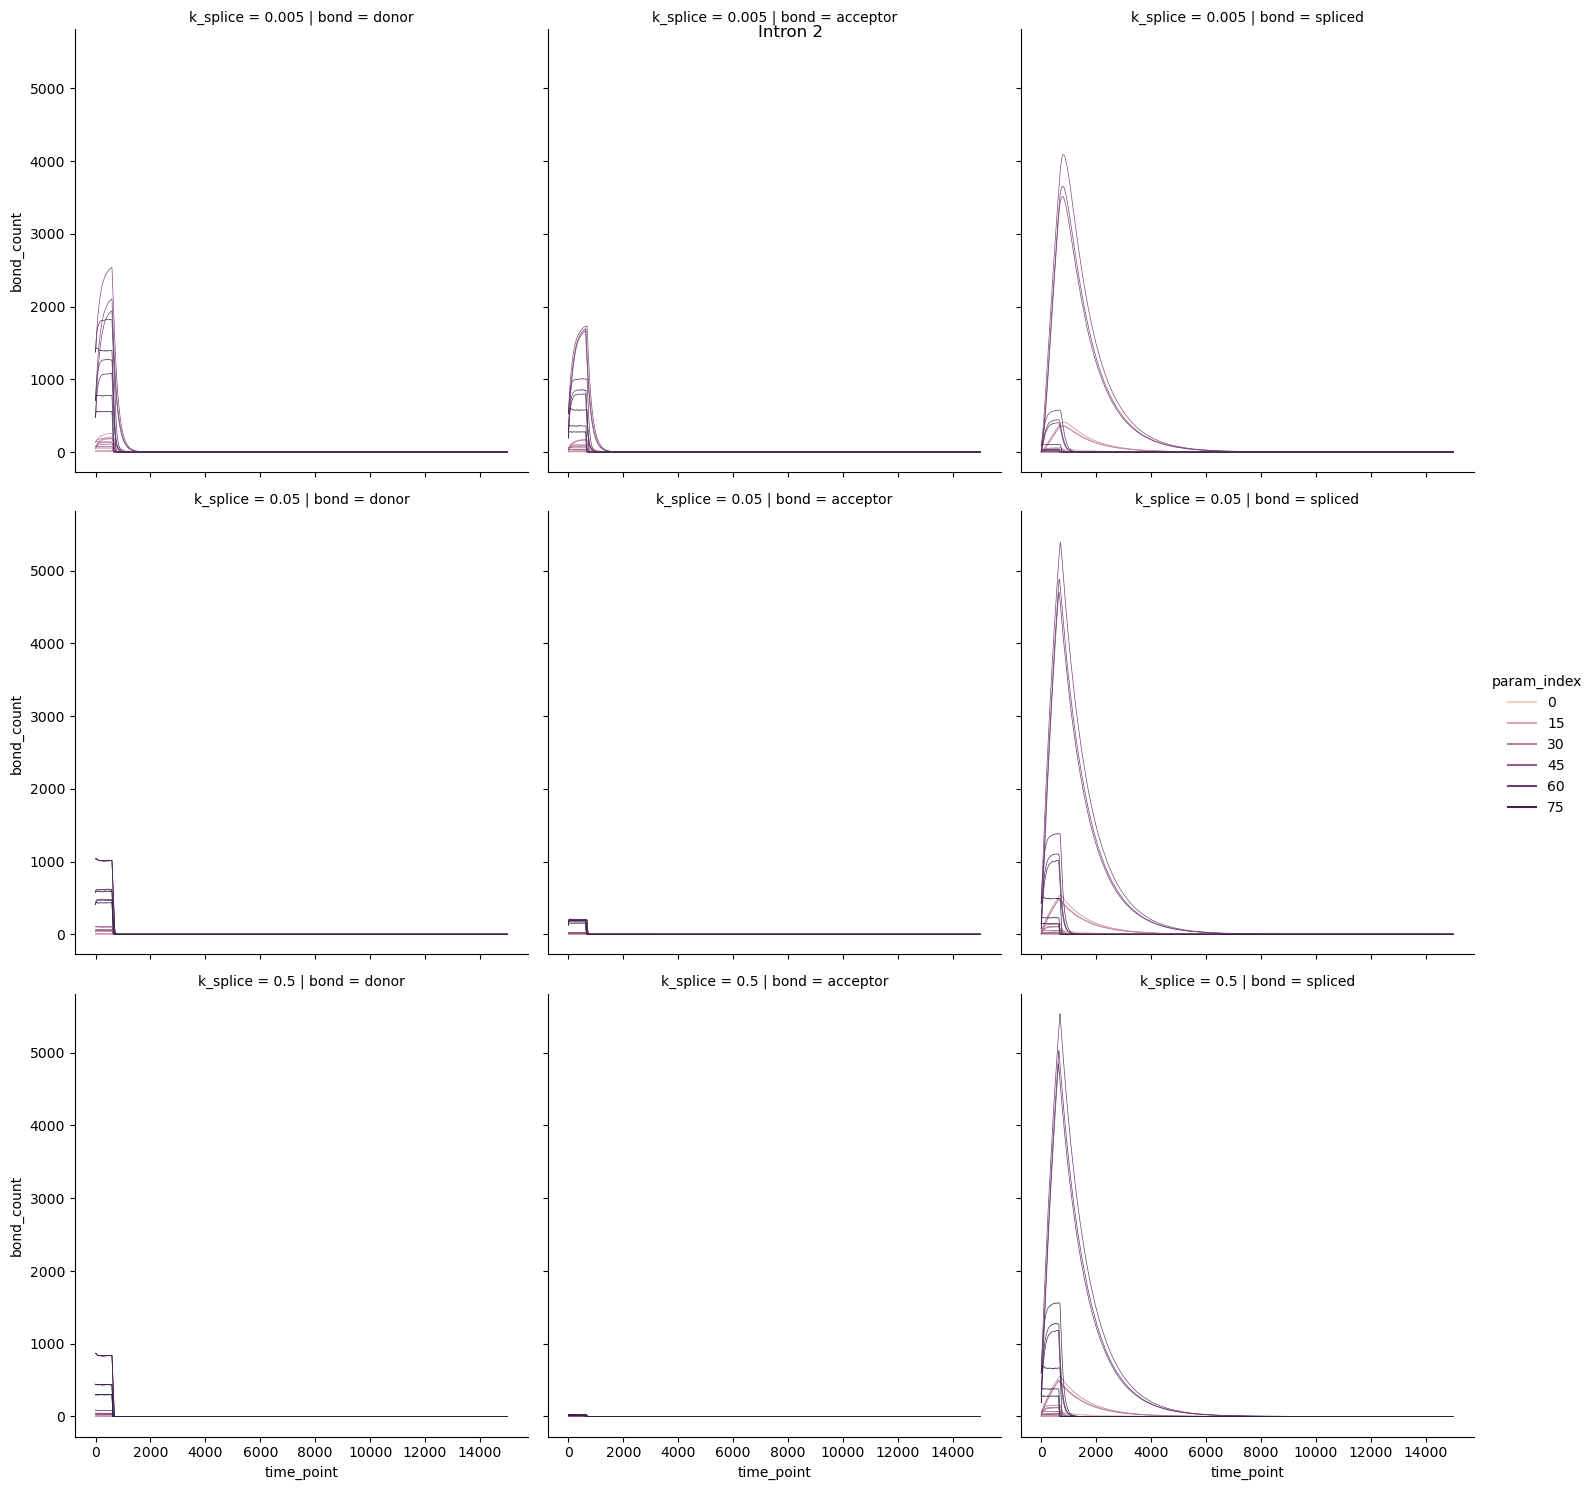

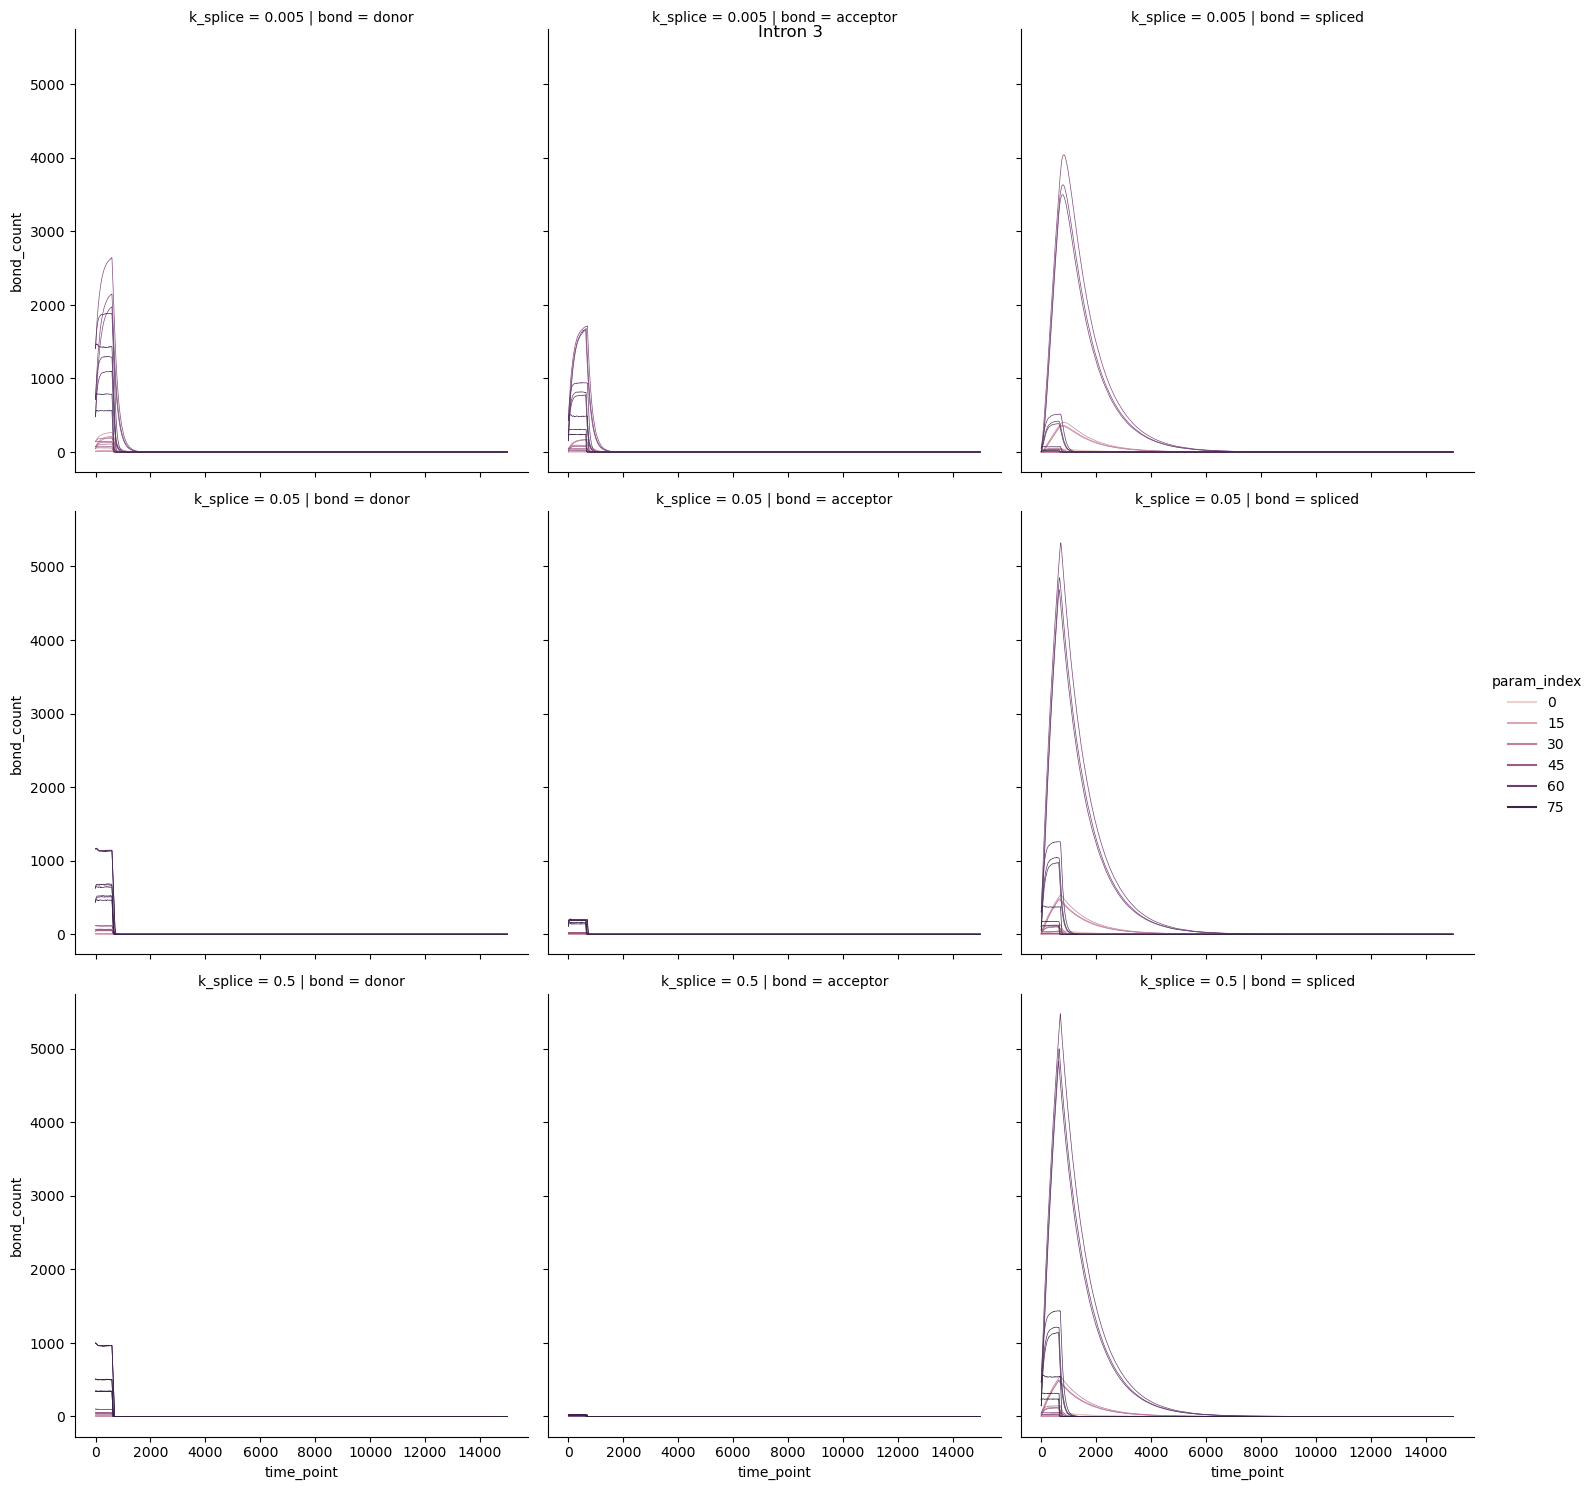

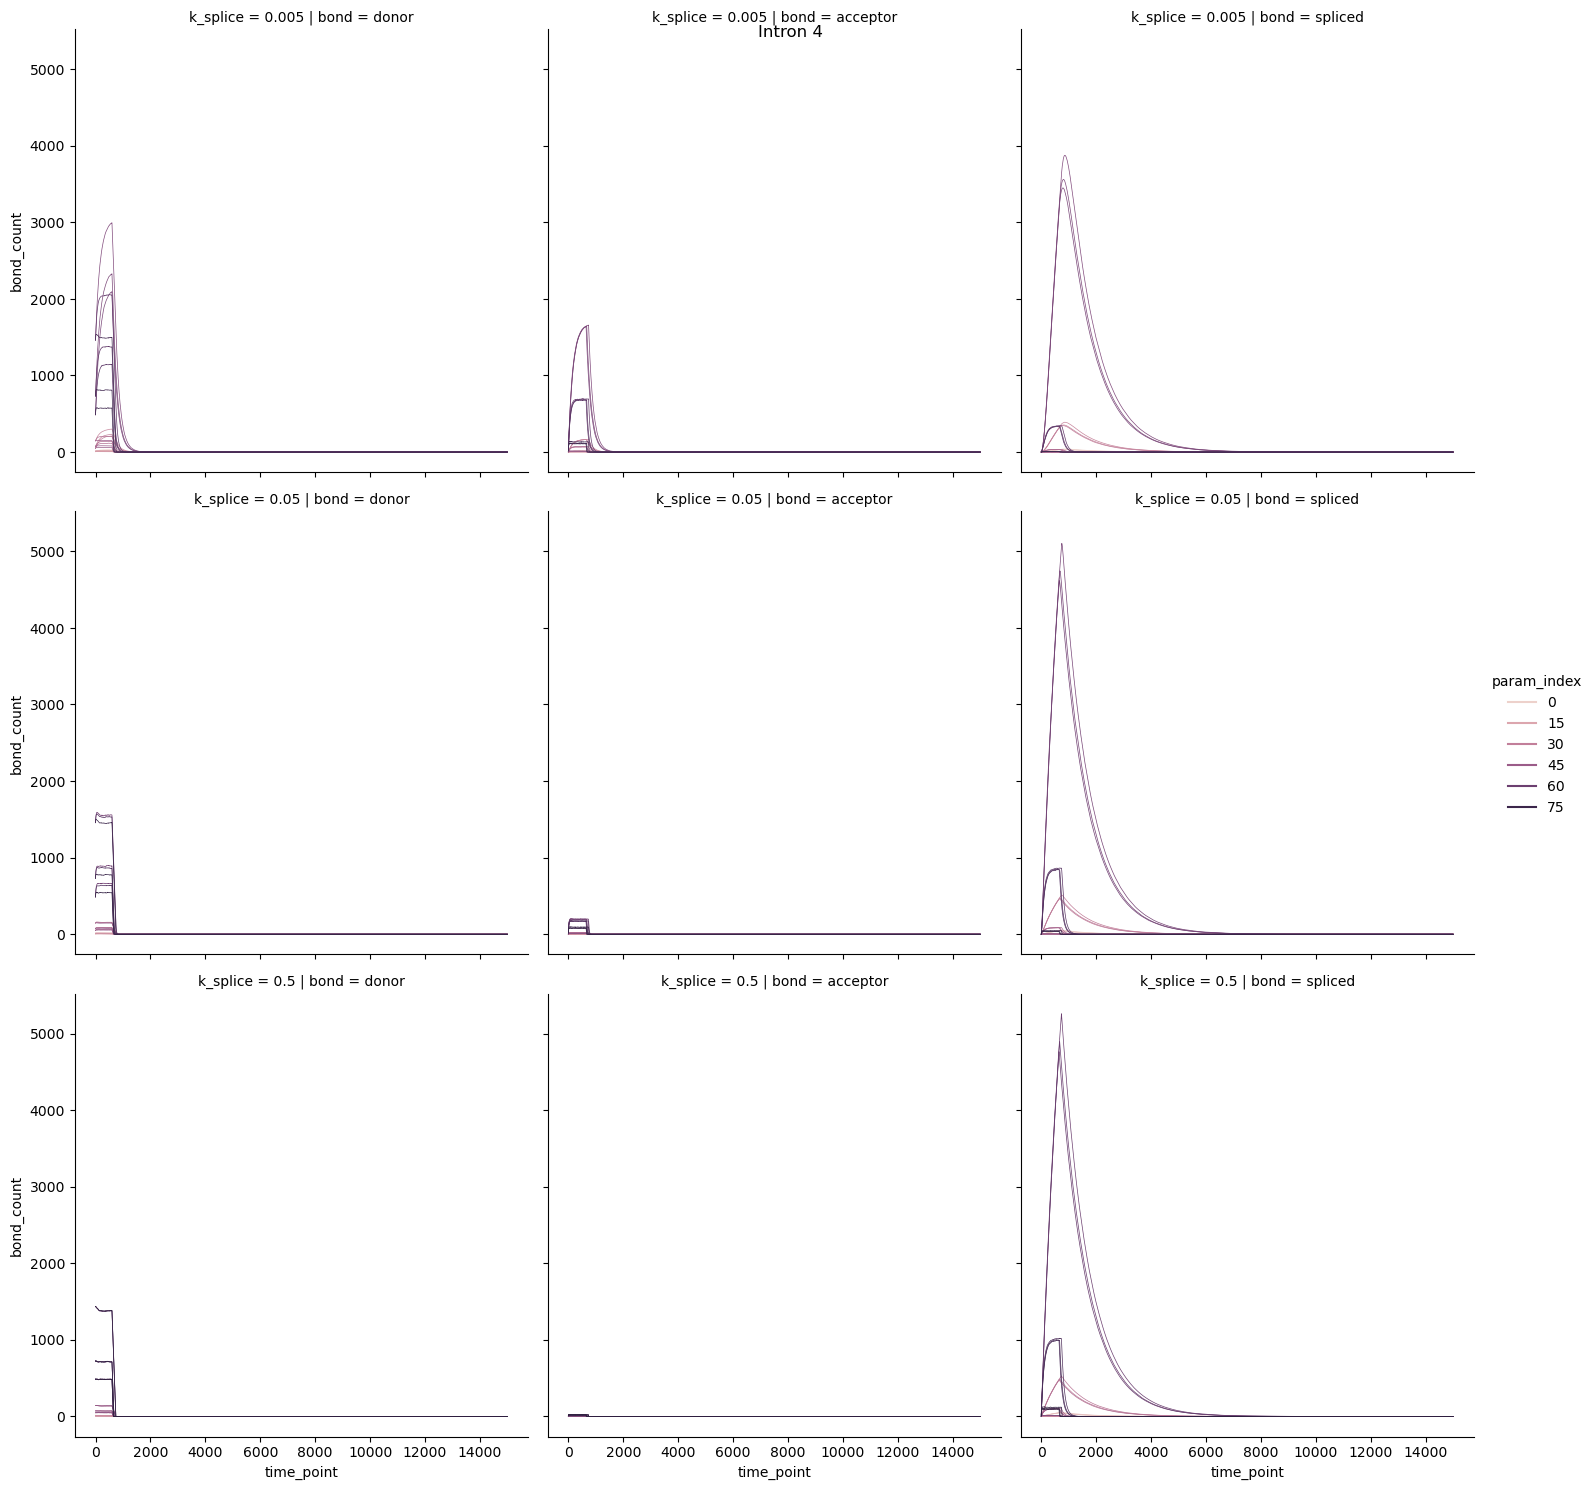

In [9]:
for i in range(n_introns):
    g = sns.relplot(
        kind='line',
        data=data_bcs.melt(
            id_vars=['time_point', 'param_index', 'bond'] + param_names,
            value_vars=[f'intron{i}'],
            var_name='intron',
            value_name='bond_count'),
        x='time_point',
        y='bond_count',
        hue='param_index',
        row='k_splice',
        col='bond',
        estimator=None,
        errorbar=None,
        linewidth=0.5)
    g.figure.suptitle(f'Intron {i}')

# Identifiability

Overview
- Splicing fraction
  - Iterative grid search
    - Estimate existing parameters
    - From existing evaluations --> estimate new parameters
  - Scipy L-BFGS-B
    - Estimate existing parameters
  - GP
    - From arbitrary x0 (random, or middle of bounds) --> estimate existing parameters
    - From existing evaluations --> estimate new parameters
- Exon and intron counts

In [103]:
fit_correlation = dict()
# Structure: {'method1': {'k_init': r, 'k_decay': r, ..., 'k_init_log10': r, ...}}

## Spliced Fraction

### Iterative Grid Search

In [7]:
df_sfs_igs = []
for index in range(n_param_values):
    file = os.path.join(dir_data_aux, 'sim_spliced_fraction', f'fit-igs-{index}.pkl')
    if os.path.exists(file):
        with open(file, 'rb') as f:
            res = pickle.load(f)
            df_sfs_igs.append(dict(
                index=index,
                x_fit=10**res['x'],
                loss=res['loss'],
                x_real=params[index]))
    else:
        print(f'{file} does not exist')
df_sfs_igs = pd.DataFrame(df_sfs_igs)

In [80]:
len(df_sfs_igs['index'].unique())

81

In [81]:
df_sfs_igs['param_diff_log10'] = np.abs(df_sfs_igs['x_fit'].map(np.log10) - df_sfs_igs['x_real'].map(np.log10)).map(np.sum)

In [82]:
for i, name in enumerate(param_names):
    df_sfs_igs[name + '_fit'] = df_sfs_igs['x_fit'].map(lambda x: x[i])
    df_sfs_igs[name] = df_sfs_igs['x_real'].map(lambda x: x[i])

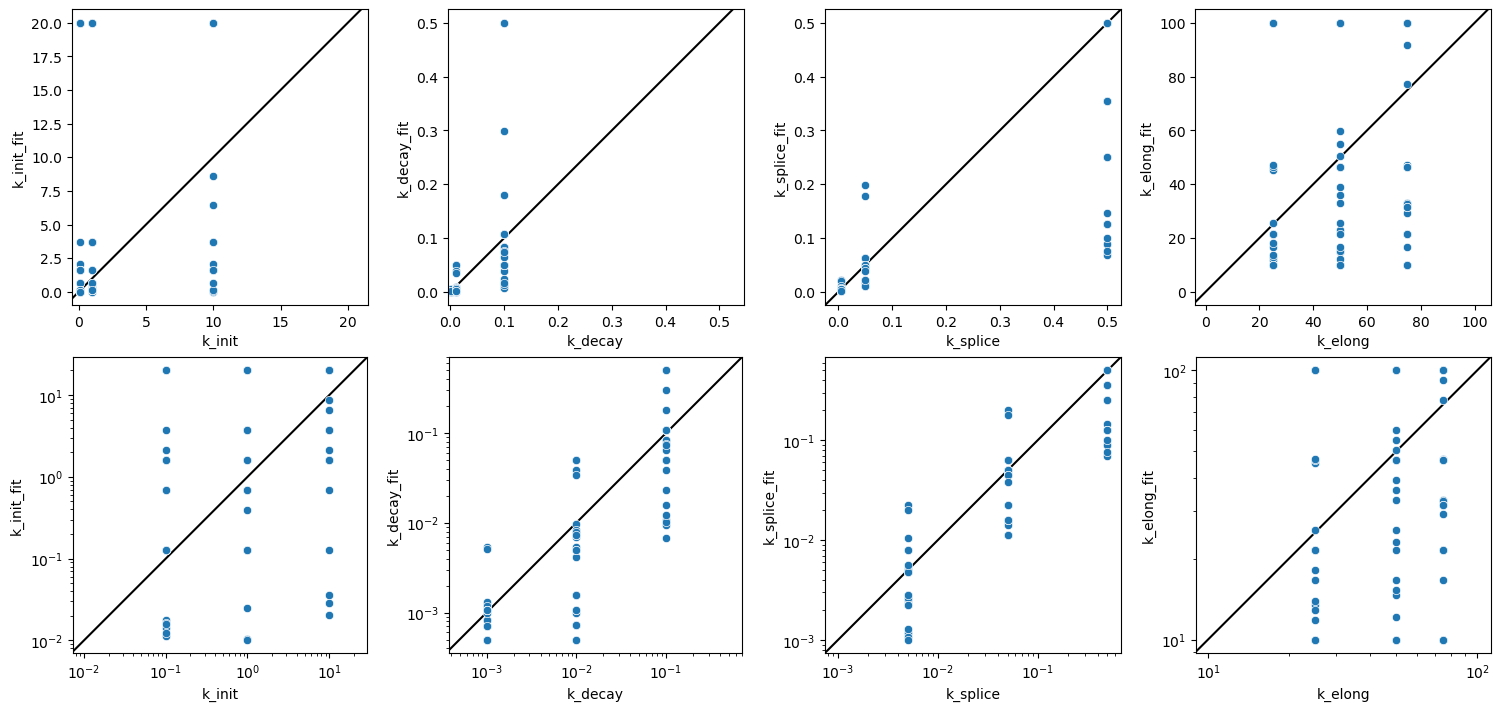

In [101]:
fig, axs = plt.subplots(2, n_params, figsize=(15, 7), constrained_layout=True)
for i, name in enumerate(param_names):
    sns.scatterplot(data=df_sfs_igs, x=name, y=name + '_fit', ax=axs[0, i])
    axs[0, i].axline((0, 0), slope=1, color='black', zorder=0)
    axs[0, i].axis('square')
    sns.scatterplot(data=df_sfs_igs, x=name, y=name + '_fit', ax=axs[1, i])
    axs[1, i].axline(
        (min(axs[1, i].dataLim.xmin, axs[1, i].dataLim.ymin),
         min(axs[1, i].dataLim.xmin, axs[1, i].dataLim.ymin)),
        slope=1,
        color='black',
        zorder=0)
    axs[1, i].set_xscale('log')
    axs[1, i].set_yscale('log')
    axs[1, i].axis('square')

In [ ]:
{'k_init': r, 'k_decay': r, ..., 'k_init_log10': r, ...}

In [109]:
a, b = np.arange(5) + np.random.rand(5), np.arange(5) + np.random.rand(5)

In [111]:
b

array([0.47785541, 1.58566607, 2.34113883, 3.76110687, 4.97931103])

In [110]:
a

array([0.60222354, 1.26995949, 2.78722669, 3.19671954, 4.8169786 ])

In [116]:
scipy.stats.pearsonr(a, b, alternative='greater')

PearsonRResult(statistic=0.9761425180123776, pvalue=0.0022038420595874857)

In [106]:
for name in param_names:
    scipy.stats.pearsonr(df_igs_sfs[name], 
    print(name)

    


k_init
k_decay
k_splice
k_elong


count    8.100000e+01
mean     4.471046e-04
std      9.496996e-04
min      2.167702e-08
25%      5.821307e-06
50%      3.622766e-05
75%      2.108308e-04
max      5.837983e-03
Name: loss, dtype: float64

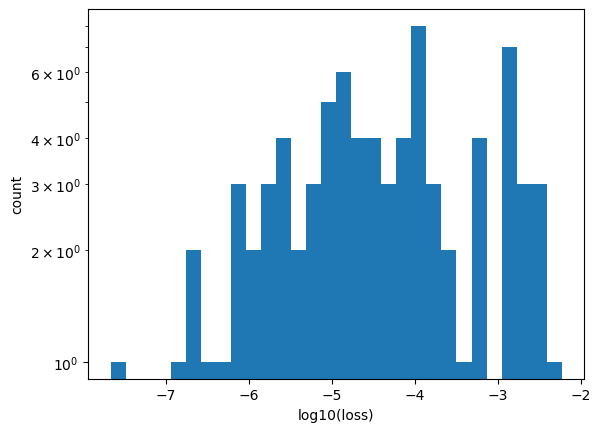

In [84]:
fig, ax = plt.subplots()
ax.hist(np.log10(df_sfs_igs['loss']), bins=30, log=True)
ax.set(xlabel='log10(loss)', ylabel='count')
df_sfs_igs['loss'].describe()

In [87]:
df_sfs_igs.columns

Index(['index', 'x_fit', 'loss', 'x_real', 'param_diff_log10', 'k_init_fit',
       'k_init', 'k_decay_fit', 'k_decay', 'k_splice_fit', 'k_splice',
       'k_elong_fit', 'k_elong'],
      dtype='object')

In [85]:
df_sfs_igs_long = df_sfs_igs.drop(columns=['func_vals', 'x_iters', 'models', 'x_fit', 'space', 'random_state', 'specs', 'x_real'])
df_sfs_igs_long = df_sfs_igs_long \
    .melt(
        id_vars=df_sfs_igs_long.columns[~df_sfs_igs_long.columns.isin(param_names)],
        value_vars=param_names,
        var_name='parameter',
        value_name='actual') \
    .rename(columns=lambda s: '_'.join(s.split('_')[:2])) \
    .melt(
        id_vars=['loss', 'index', 'parameter', 'actual'],
        value_vars=param_names,
        var_name='parameter2',
        value_name='fit') \
    .pipe(lambda df: df.loc[df['parameter'] == df['parameter2']]) \
    .drop(columns=['parameter2'])
df_sfs_igs_long['rank'] = df_sfs_igs_long.groupby(['parameter'])['actual'].rank(method='dense')

KeyError: "['func_vals', 'x_iters', 'models', 'space', 'random_state', 'specs'] not found in axis"

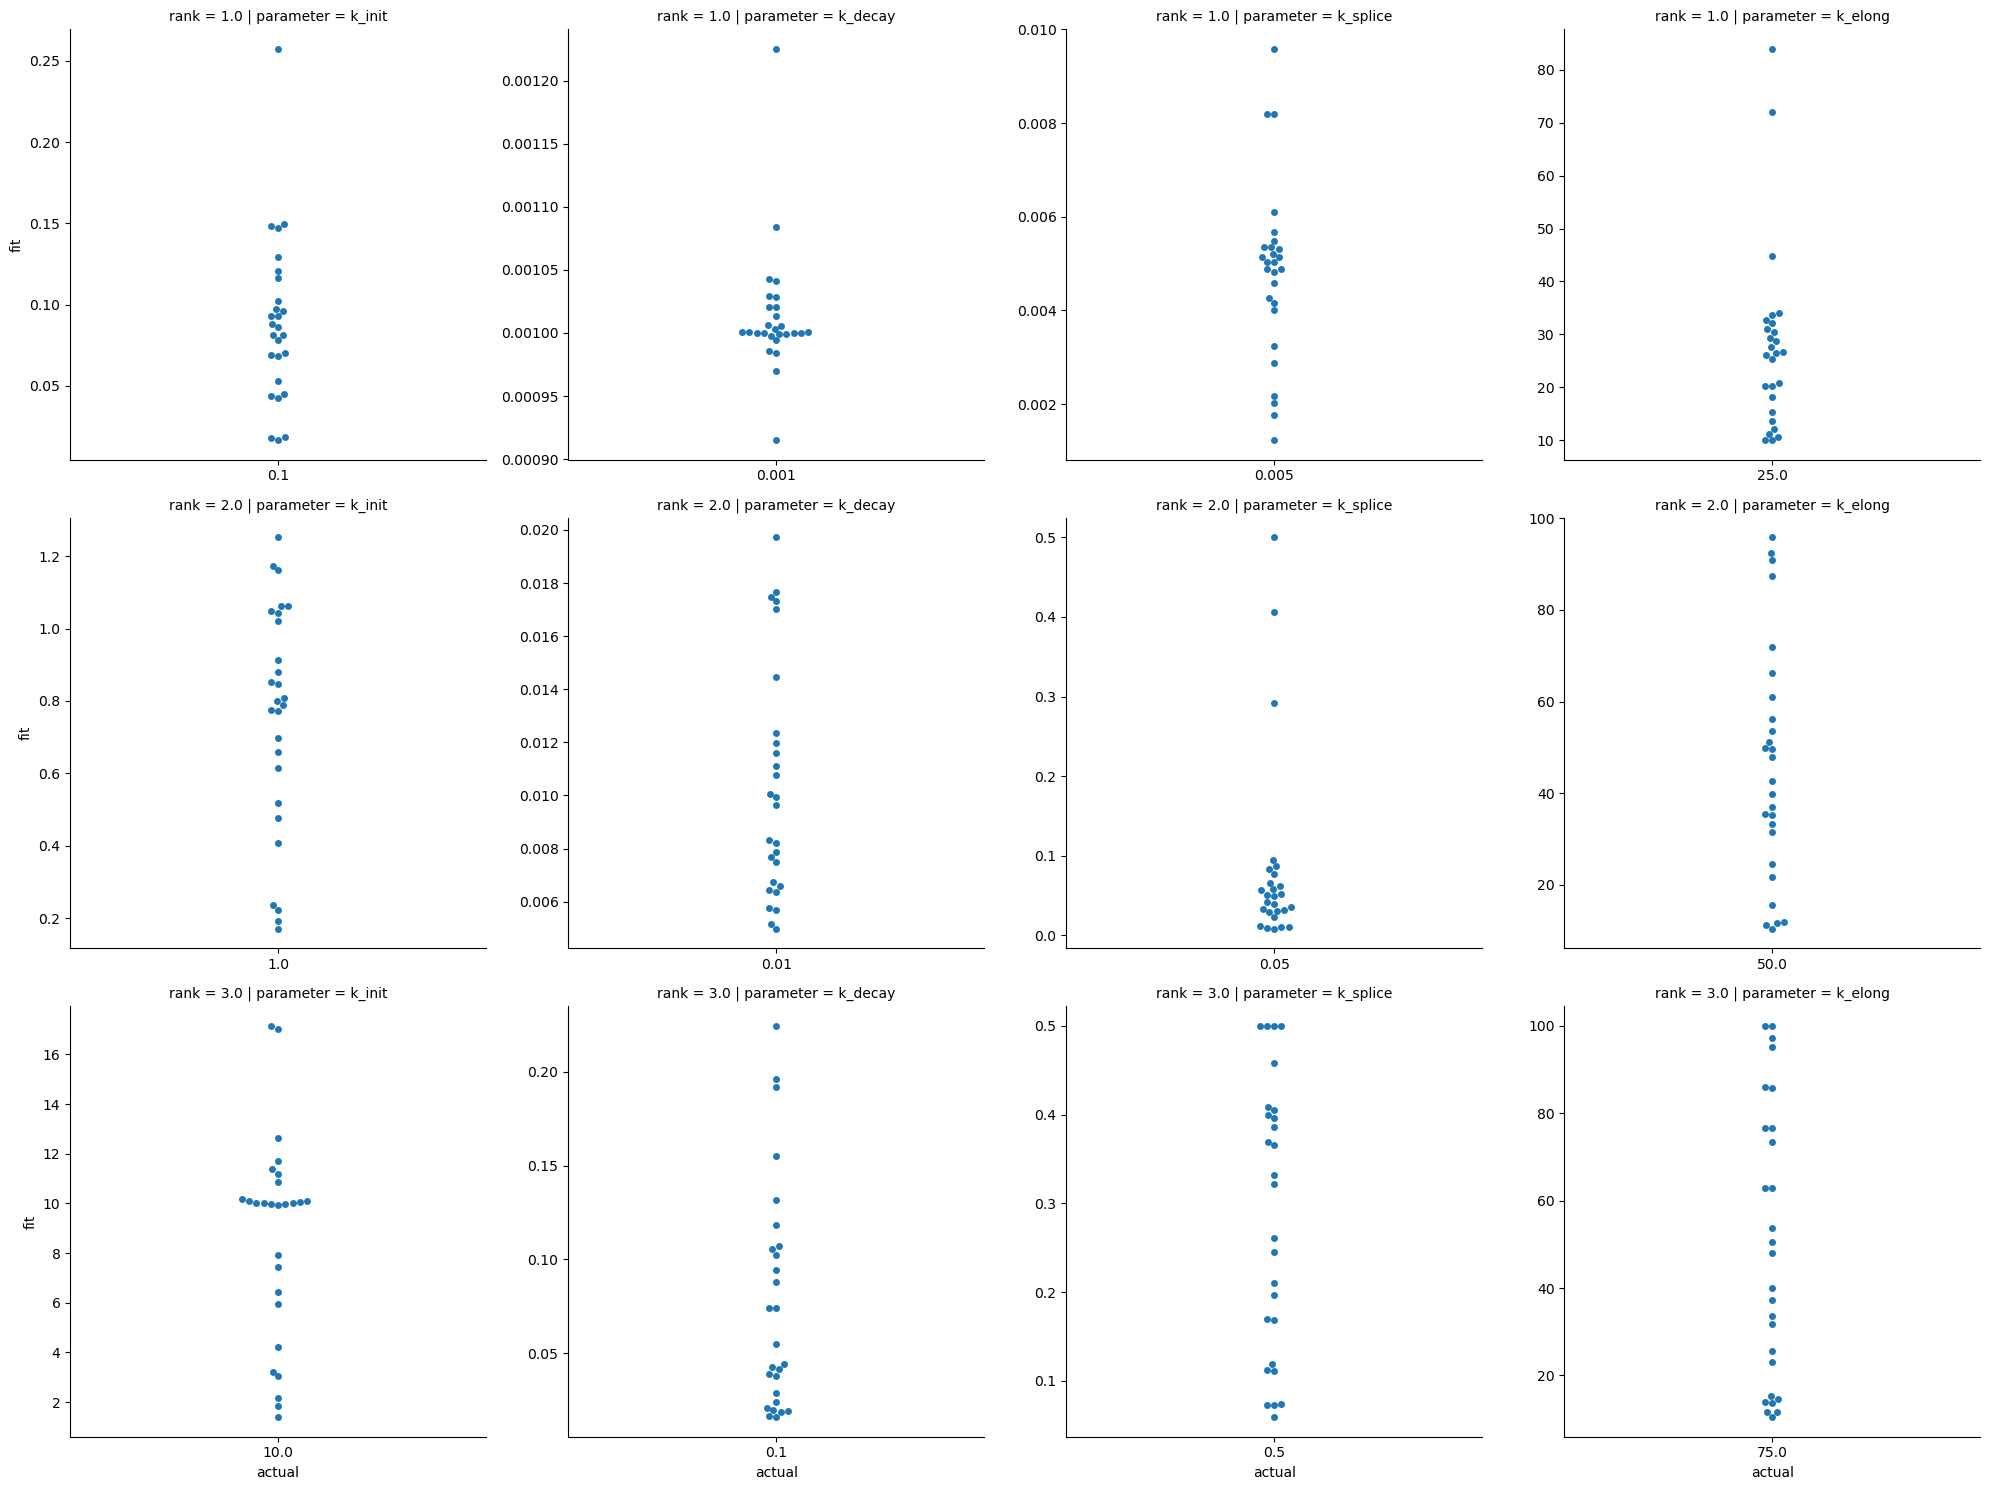

In [223]:
sns.catplot(
    kind='swarm',
    data=df_sfs_igs_long,
    x='actual',
    y='fit',
    col='parameter',
    row='rank',
    sharex=False,
    sharey=False)

### L-BFGS-B

In [79]:
df_sfs_lbfgsb = []
for index in range(n_param_values):
    file = os.path.join(dir_data_aux, 'sim_spliced_fraction', f'fit-lbfgsb-{index}.pkl')
    if os.path.exists(file):
        with open(file, 'rb') as f:
            res = pickle.load(f)
            del res['hess_inv'], res['jac']
            res.update(dict(index=index, x_real=params[index]))
            df_sfs_lbfgsb.append(dict(res))
df_sfs_lbfgsb = pd.DataFrame(df_sfs_lbfgsb).rename(columns=dict(x='x_fit', fun='loss'))
df_sfs_lbfgsb['x_fit'] = df_sfs_lbfgsb['x_fit'].map(lambda x: 10**x)

In [74]:
len(df_sfs_lbfgsb['index'].unique())

81

In [81]:
for col in ['nfev', 'nit', 'status', 'message', 'success']:
    display(df_sfs_lbfgsb[col].value_counts())
    print()

105    16
140     9
130     6
115     6
135     5
145     5
150     4
165     4
125     3
110     3
160     3
155     2
95      2
80      2
120     2
100     2
190     1
170     1
180     1
90      1
185     1
175     1
245     1
Name: nfev, dtype: int64

3    28
2    21
0    10
1     9
4     7
5     5
6     1
Name: nit, dtype: int64

0    70
2    11
Name: status, dtype: int64

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH    70
ABNORMAL_TERMINATION_IN_LNSRCH                     11
Name: message, dtype: int64

True     70
False    11
Name: success, dtype: int64

In [82]:
for i, name in enumerate(param_names):
    df_sfs_lbfgsb[name + '_fit'] = df_sfs_lbfgsb['x_fit'].map(lambda x: x[i])
    df_sfs_lbfgsb[name] = df_sfs_lbfgsb['x_real'].map(lambda x: x[i])

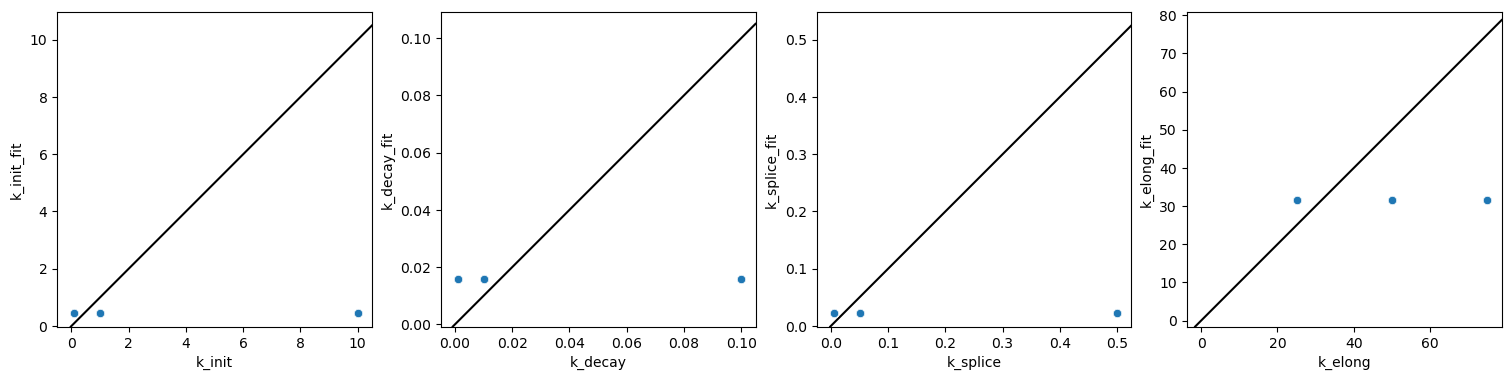

In [99]:
fig, axs = plt.subplots(1, n_params, figsize=(15, 5), constrained_layout=True)
for i, name in enumerate(param_names):
    sns.scatterplot(data=df_sfs_lbfgsb, x=name, y=name + '_fit', ax=axs[i])
    axs[i].axline((0, 0), slope=1, color='black', zorder=0)
    axs[i].axis('square')

### Gaussian Processes

In [142]:
df_sfs_gp = []
for index in tqdm(range(n_param_values)):
    file = os.path.join(dir_data_aux, 'sim_spliced_fraction', f'fit-gp-{index}.pkl.gz')
    if os.path.exists(file):
        res = skopt.load(file)
        res.update(dict(index=index, x_real=params[index]))
        df_sfs_gp.append(dict(res))
df_sfs_gp = pd.DataFrame(df_sfs_gp).rename(columns=dict(x='x_fit', fun='loss'))
df_sfs_gp['x_fit'] = df_sfs_gp['x_fit'].map(lambda x: 10**np.array(x))

In [143]:
len(df_sfs_gp['index'].unique())

81

In [150]:
for i, name in enumerate(param_names):
    df_sfs_gp[name + '_fit'] = df_sfs_gp['x_fit'].map(lambda x: x[i])
    df_sfs_gp[name] = df_sfs_gp['x_real'].map(lambda x: x[i])

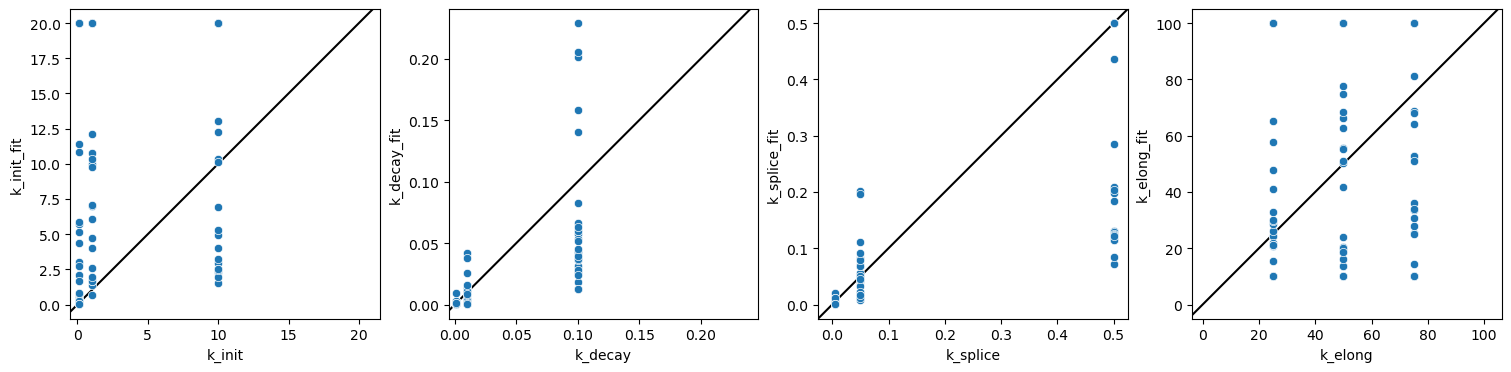

In [151]:
fig, axs = plt.subplots(1, n_params, figsize=(15, 5), constrained_layout=True)
for i, name in enumerate(param_names):
    sns.scatterplot(data=df_sfs_gp, x=name, y=name + '_fit', ax=axs[i])
    axs[i].axline((0, 0), slope=1, color='black', zorder=0)
    axs[i].axis('square')

count    8.100000e+01
mean     2.326117e-04
std      4.589634e-04
min      1.537403e-08
25%      7.338462e-06
50%      3.366918e-05
75%      1.752398e-04
max      1.964310e-03
Name: loss, dtype: float64

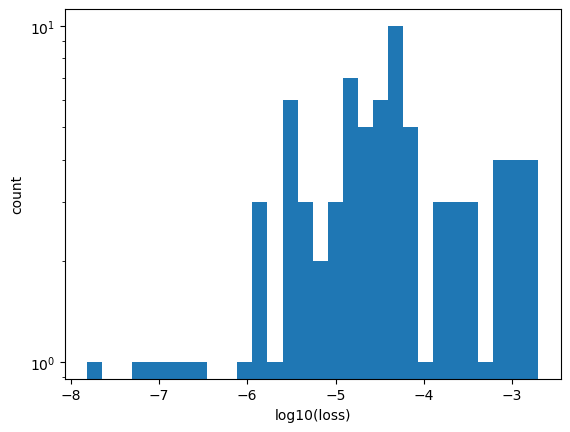

In [152]:
fig, ax = plt.subplots()
ax.hist(np.log10(df_sfs_gp['loss']), bins=30, log=True)
ax.set(xlabel='log10(loss)', ylabel='count')
df_sfs_gp['loss'].describe()

## Bond Counts

### Iterative Grid Search

In [101]:
df_bcs_igs = []
for index in range(n_param_values):
    file = os.path.join(dir_data_aux, 'sim_bond_counts', f'fit-igs-{index}.pkl')
    if os.path.exists(file):
        with open(file, 'rb') as f:
            res = pickle.load(f)
            df_bcs_igs.append(dict(
                index=index,
                x_fit=10**res['x'],
                loss=res['loss'],
                x_real=params[index]))
df_bcs_igs = pd.DataFrame(df_bcs_igs)

In [102]:
len(df_bcs_igs['index'].unique())

81

In [103]:
df_bcs_igs['param_diff_log10'] = np.abs(df_bcs_igs['x_fit'].map(np.log10) - df_bcs_igs['x_real'].map(np.log10)).map(np.sum)

In [104]:
for i, name in enumerate(param_names):
    df_bcs_igs[name + '_fit'] = df_bcs_igs['x_fit'].map(lambda x: x[i])
    df_bcs_igs[name] = df_bcs_igs['x_real'].map(lambda x: x[i])

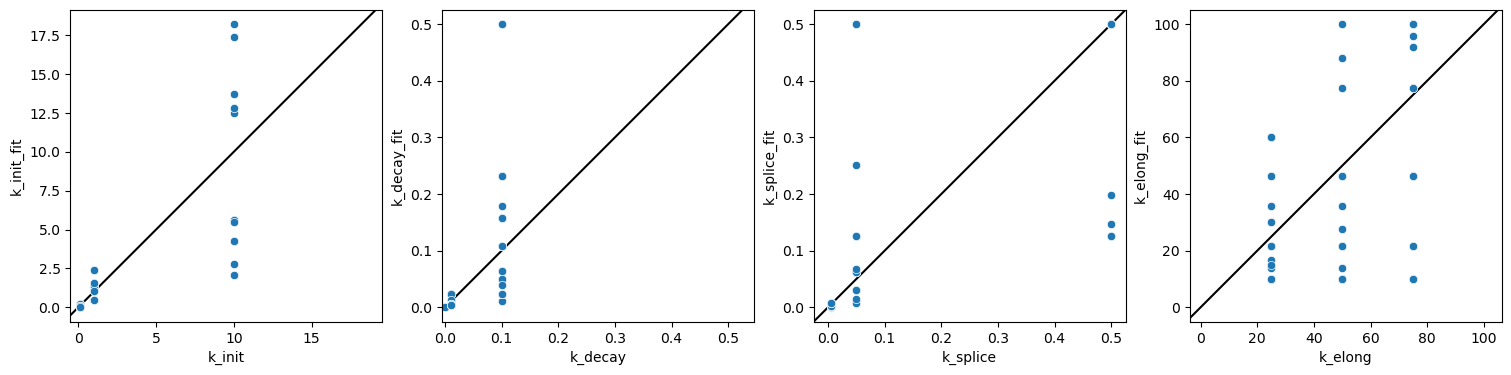

In [105]:
fig, axs = plt.subplots(1, n_params, figsize=(15, 5), constrained_layout=True)
for i, name in enumerate(param_names):
    sns.scatterplot(data=df_bcs_igs, x=name, y=name + '_fit', ax=axs[i])
    axs[i].axline((0, 0), slope=1, color='black', zorder=0)
    axs[i].axis('square')

count    8.100000e+01
mean     1.287191e+06
std      3.623850e+06
min      3.672778e-01
25%      4.996182e+01
50%      1.077866e+03
75%      1.204534e+05
max      1.449373e+07
Name: loss, dtype: float64

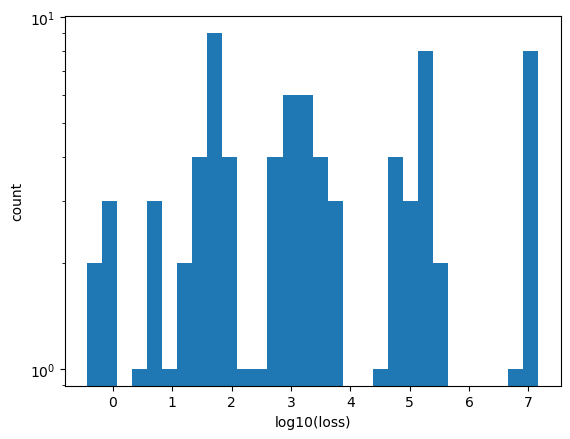

In [115]:
fig, ax = plt.subplots()
ax.hist(np.log10(df_bcs_igs['loss']), bins=30, log=True)
ax.set(xlabel='log10(loss)', ylabel='count')
df_bcs_igs['loss'].describe()

### L-BFGS-B

In [119]:
df_bcs_lbfgsb = []
for index in range(n_param_values):
    file = os.path.join(dir_data_aux, 'sim_bond_counts', f'fit-lbfgsb-{index}.pkl')
    if os.path.exists(file):
        with open(file, 'rb') as f:
            res = pickle.load(f)
            del res['hess_inv'], res['jac']
            res.update(dict(index=index, x_real=params[index]))
            df_bcs_lbfgsb.append(dict(res))
df_bcs_lbfgsb = pd.DataFrame(df_bcs_lbfgsb).rename(columns=dict(x='x_fit', fun='loss'))
df_bcs_lbfgsb['x_fit'] = df_bcs_lbfgsb['x_fit'].map(lambda x: 10**x)

In [120]:
len(df_bcs_lbfgsb['index'].unique())

81

In [121]:
for col in ['nfev', 'nit', 'status', 'message', 'success']:
    display(df_bcs_lbfgsb[col].value_counts())
    print()

105    12
120    11
115     8
130     5
95      5
150     5
135     4
100     4
140     4
110     4
80      3
160     3
125     3
200     2
175     2
190     2
210     1
85      1
165     1
145     1
Name: nfev, dtype: int64

2    29
3    23
4    11
0    10
1     6
5     2
Name: nit, dtype: int64

0    70
2    11
Name: status, dtype: int64

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH    70
ABNORMAL_TERMINATION_IN_LNSRCH                     11
Name: message, dtype: int64

True     70
False    11
Name: success, dtype: int64

In [122]:
for i, name in enumerate(param_names):
    df_bcs_lbfgsb[name + '_fit'] = df_bcs_lbfgsb['x_fit'].map(lambda x: x[i])
    df_bcs_lbfgsb[name] = df_bcs_lbfgsb['x_real'].map(lambda x: x[i])

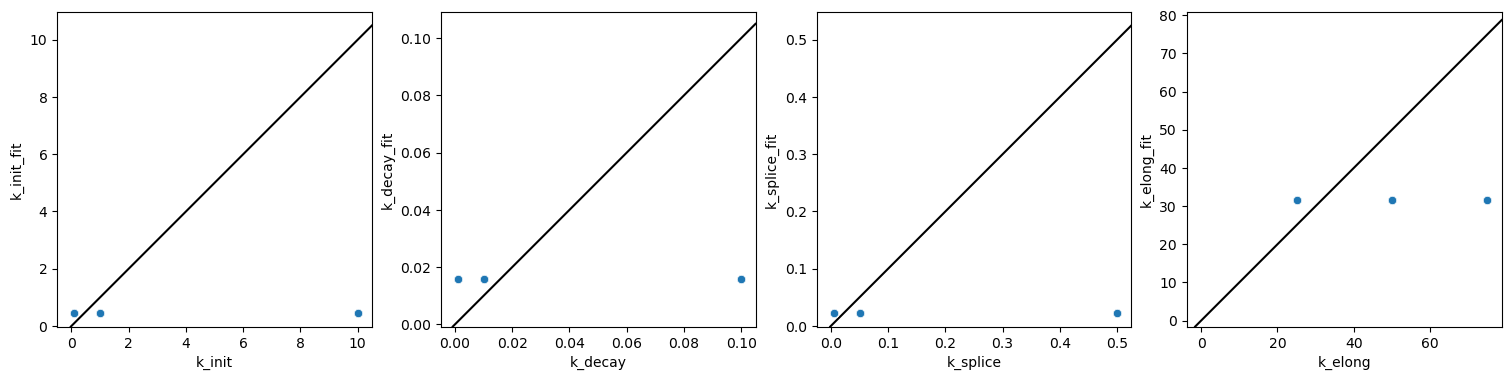

In [123]:
fig, axs = plt.subplots(1, n_params, figsize=(15, 5), constrained_layout=True)
for i, name in enumerate(param_names):
    sns.scatterplot(data=df_bcs_lbfgsb, x=name, y=name + '_fit', ax=axs[i])
    axs[i].axline((0, 0), slope=1, color='black', zorder=0)
    axs[i].axis('square')

count    8.100000e+01
mean     2.423145e+07
std      6.376072e+07
min      1.335552e+03
25%      1.529403e+04
50%      5.453193e+04
75%      5.955374e+06
max      2.506649e+08
Name: loss, dtype: float64

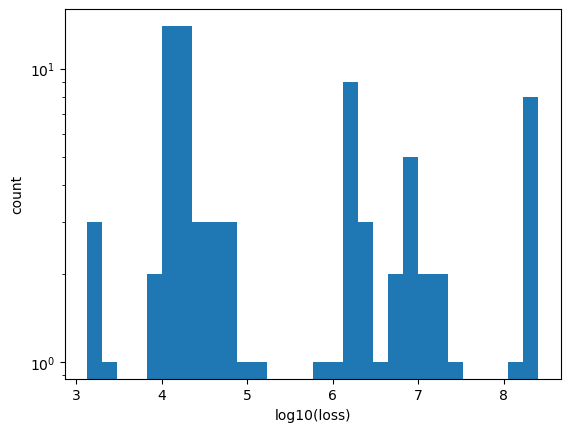

In [128]:
fig, ax = plt.subplots()
ax.hist(np.log10(df_bcs_lbfgsb['loss']), bins=30, log=True)
ax.set(xlabel='log10(loss)', ylabel='count')
df_bcs_lbfgsb['loss'].describe()

### Gaussian Processes

In [158]:
df_bcs_gp = []
for index in tqdm(range(n_param_values)):
    file = os.path.join(dir_data_aux, 'sim_bond_counts', f'fit-gp-{index}.pkl.gz')
    if os.path.exists(file):
        res = skopt.load(file)
        res.update(dict(index=index, x_real=params[index]))
        df_bcs_gp.append(dict(res))
df_bcs_gp = pd.DataFrame(df_bcs_gp).rename(columns=dict(x='x_fit', fun='loss'))
df_bcs_gp['x_fit'] = df_bcs_gp['x_fit'].map(lambda x: 10**np.array(x))

  0%|          | 0/81 [00:00<?, ?it/s]

In [159]:
len(df_bcs_gp['index'].unique())

81

In [160]:
for i, name in enumerate(param_names):
    df_bcs_gp[name + '_fit'] = df_bcs_gp['x_fit'].map(lambda x: x[i])
    df_bcs_gp[name] = df_bcs_gp['x_real'].map(lambda x: x[i])

Text(0.5, 0.98, 'Gaussian Process Fit of Bond Counts')

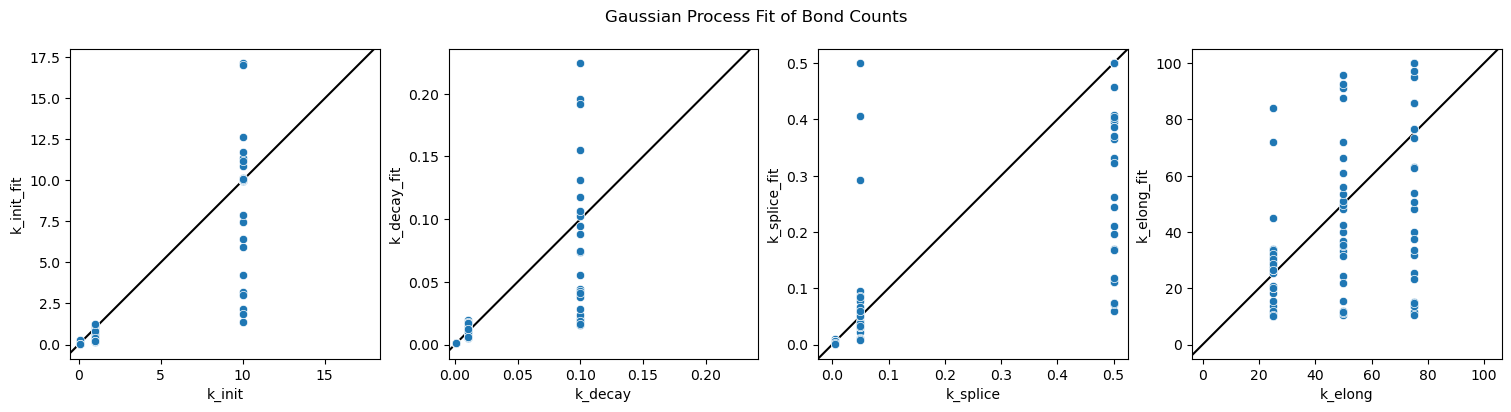

In [176]:
fig, axs = plt.subplots(1, n_params, figsize=(15, 4), constrained_layout=True)
for i, name in enumerate(param_names):
    sns.scatterplot(data=df_bcs_gp, x=name, y=name + '_fit', ax=axs[i])
    axs[i].axline((0, 0), slope=1, color='black', zorder=0)
    axs[i].axis('square')
fig.suptitle('Gaussian Process Fit of Bond Counts')

In [201]:
df_bcs_gp_long = df_bcs_gp.drop(columns=['func_vals', 'x_iters', 'models', 'x_fit', 'space', 'random_state', 'specs', 'x_real'])
df_bcs_gp_long = df_bcs_gp_long \
    .melt(
        id_vars=df_bcs_gp_long.columns[~df_bcs_gp_long.columns.isin(param_names)],
        value_vars=param_names,
        var_name='parameter',
        value_name='actual') \
    .rename(columns=lambda s: '_'.join(s.split('_')[:2])) \
    .melt(
        id_vars=['loss', 'index', 'parameter', 'actual'],
        value_vars=param_names,
        var_name='parameter2',
        value_name='fit') \
    .pipe(lambda df: df.loc[df['parameter'] == df['parameter2']]) \
    .drop(columns=['parameter2'])
df_bcs_gp_long['rank'] = df_bcs_gp_long.groupby(['parameter'])['actual'].rank(method='dense')

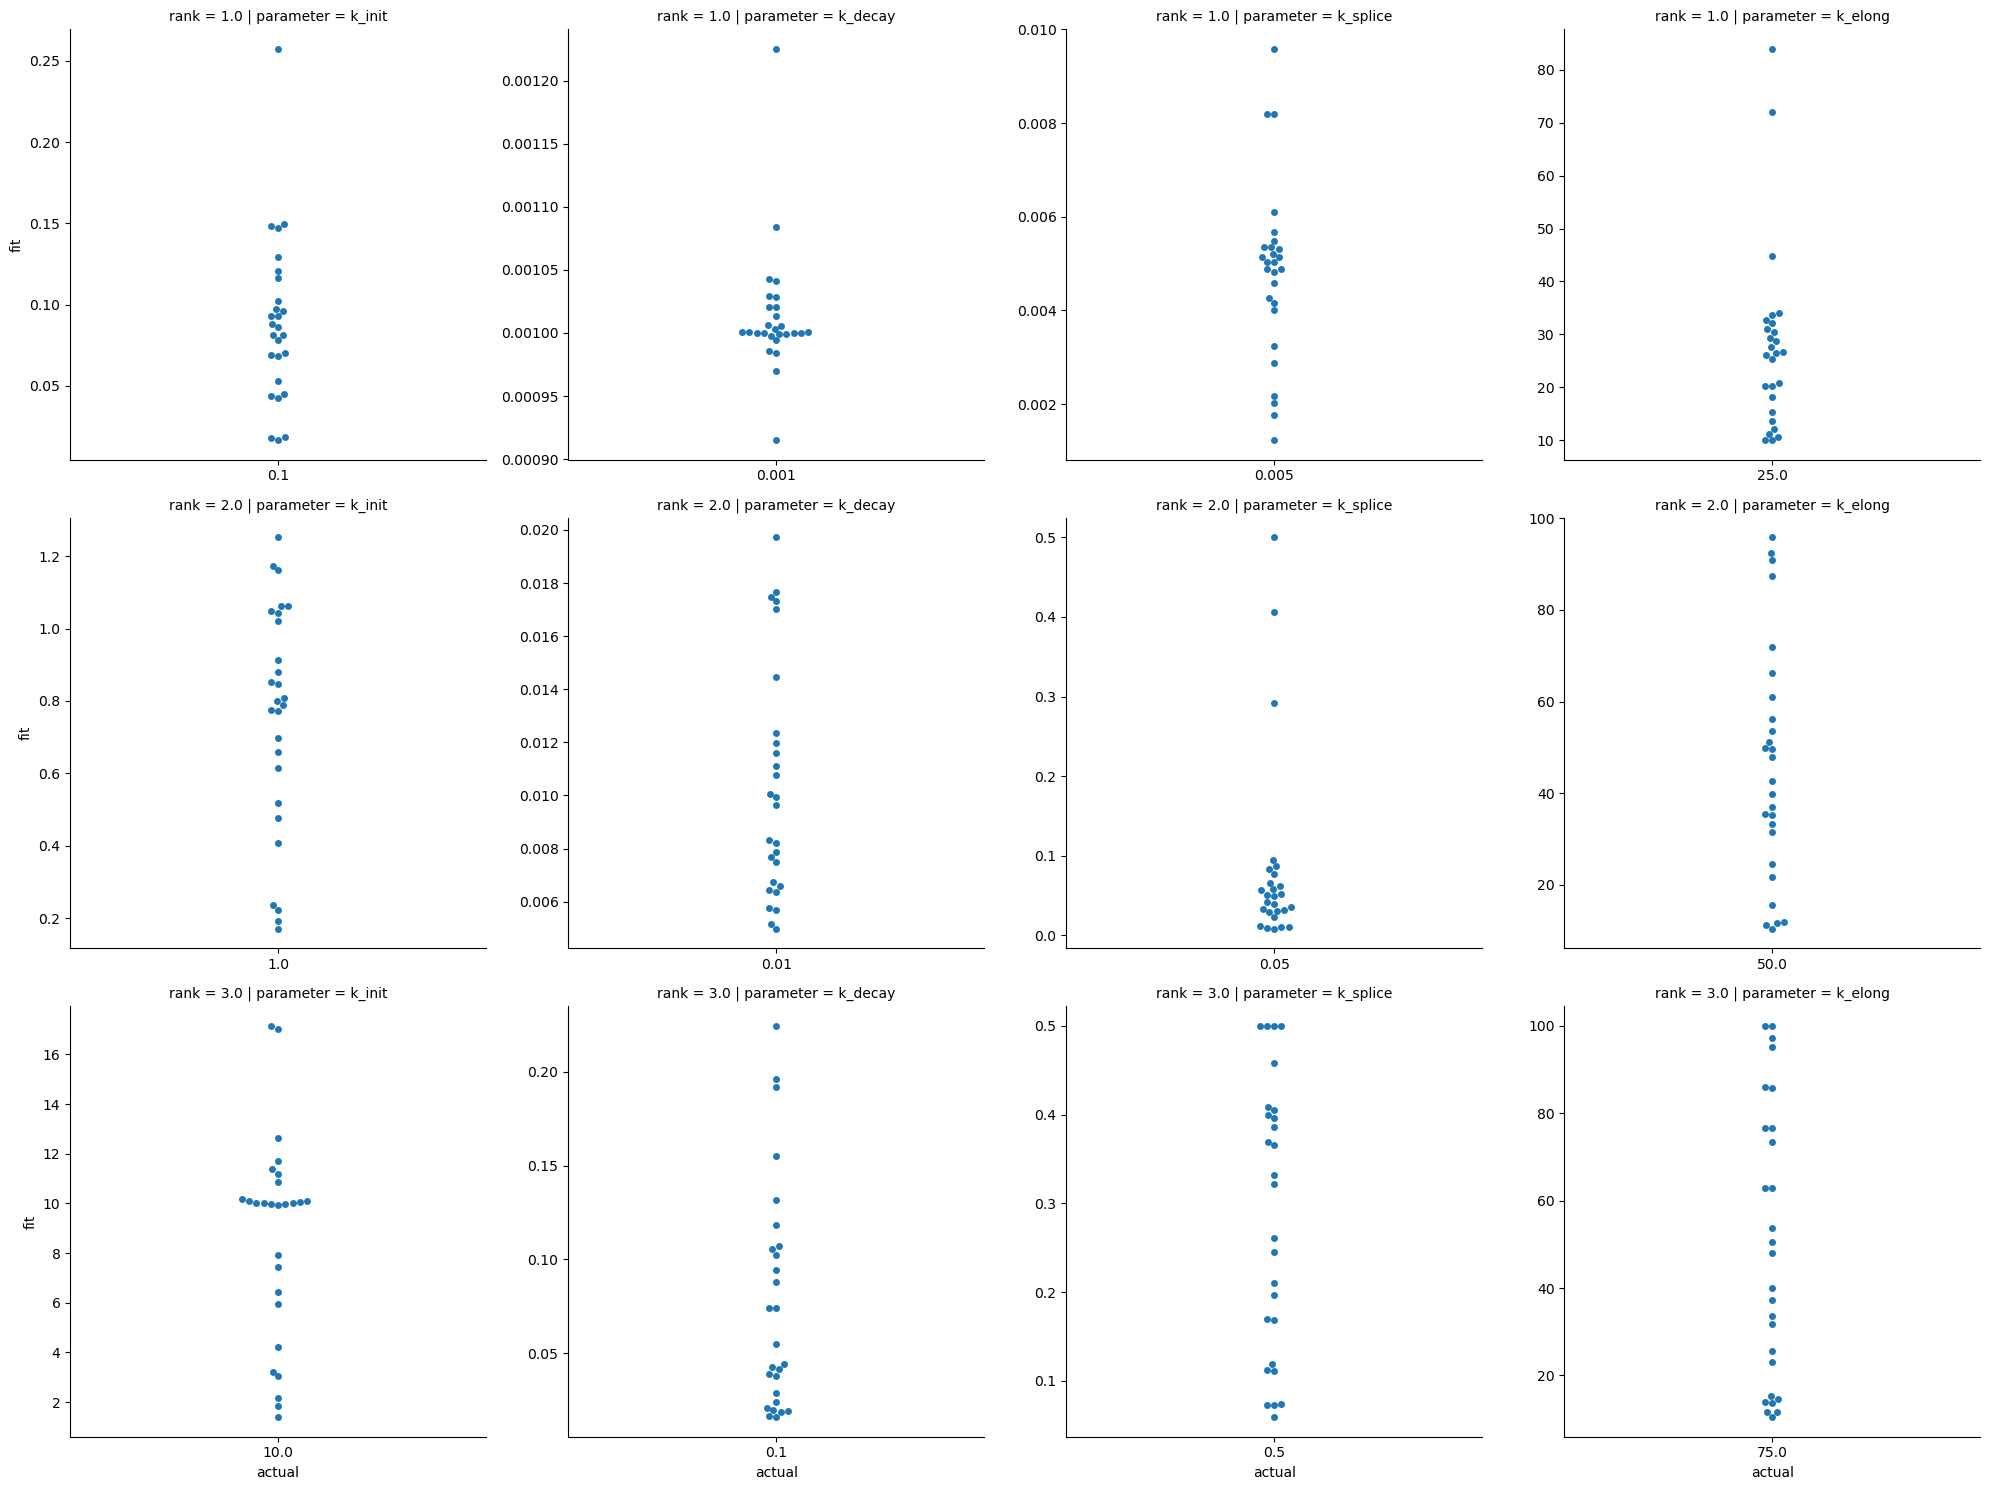

In [223]:
sns.catplot(
    kind='swarm',
    data=df_bcs_gp_long,
    x='actual',
    y='fit',
    col='parameter',
    row='rank',
    sharex=False,
    sharey=False)

count    8.100000e+01
mean     2.566342e+04
std      2.116425e+05
min      3.520000e-01
25%      1.614870e+01
50%      1.992353e+02
75%      1.015024e+03
max      1.906105e+06
Name: loss, dtype: float64

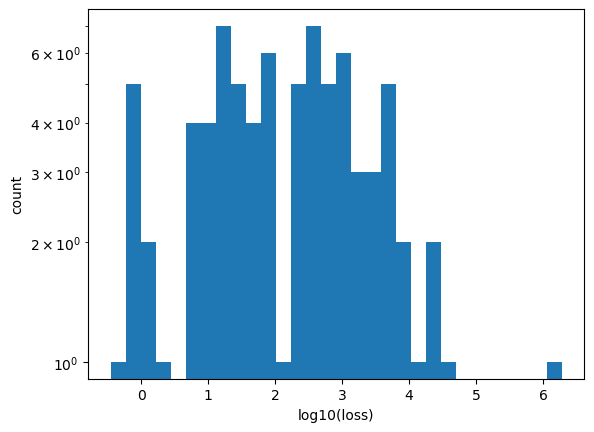

In [162]:
fig, ax = plt.subplots()
ax.hist(np.log10(df_bcs_gp['loss']), bins=30, log=True)
ax.set(xlabel='log10(loss)', ylabel='count')
df_bcs_gp['loss'].describe()

#### Dissecting a specific fit

In [236]:
index

80

In [174]:
np.log10(params[index])

array([ 1.        , -1.        , -0.30103   ,  1.87506126])

In [171]:
10**np.array(res.x)

array([ 1.38982248,  0.01618845,  0.07336499, 10.43799497])

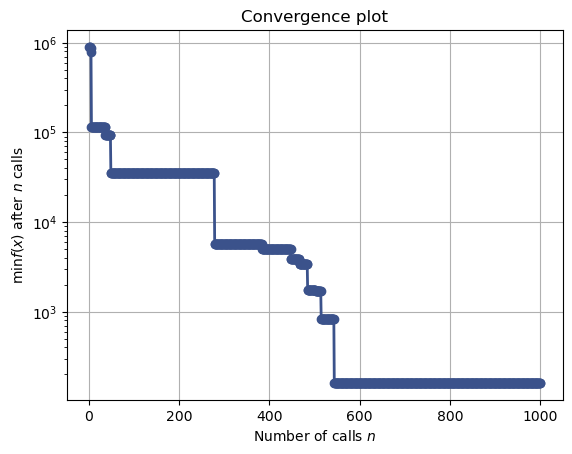

In [166]:
ax = skopt.plots.plot_convergence(res)
ax.set_yscale('log')

array([[<AxesSubplot: xlabel='k_init', ylabel='Number of samples'>,
        <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >],
       [<AxesSubplot: ylabel='k_decay'>,
        <AxesSubplot: xlabel='k_decay', ylabel='Number of samples'>,
        <AxesSubplot: >, <AxesSubplot: >],
       [<AxesSubplot: ylabel='k_splice'>, <AxesSubplot: >,
        <AxesSubplot: xlabel='k_splice', ylabel='Number of samples'>,
        <AxesSubplot: >],
       [<AxesSubplot: xlabel='k_init', ylabel='k_elong'>,
        <AxesSubplot: xlabel='k_decay'>,
        <AxesSubplot: xlabel='k_splice'>,
        <AxesSubplot: xlabel='k_elong', ylabel='Number of samples'>]],
      dtype=object)

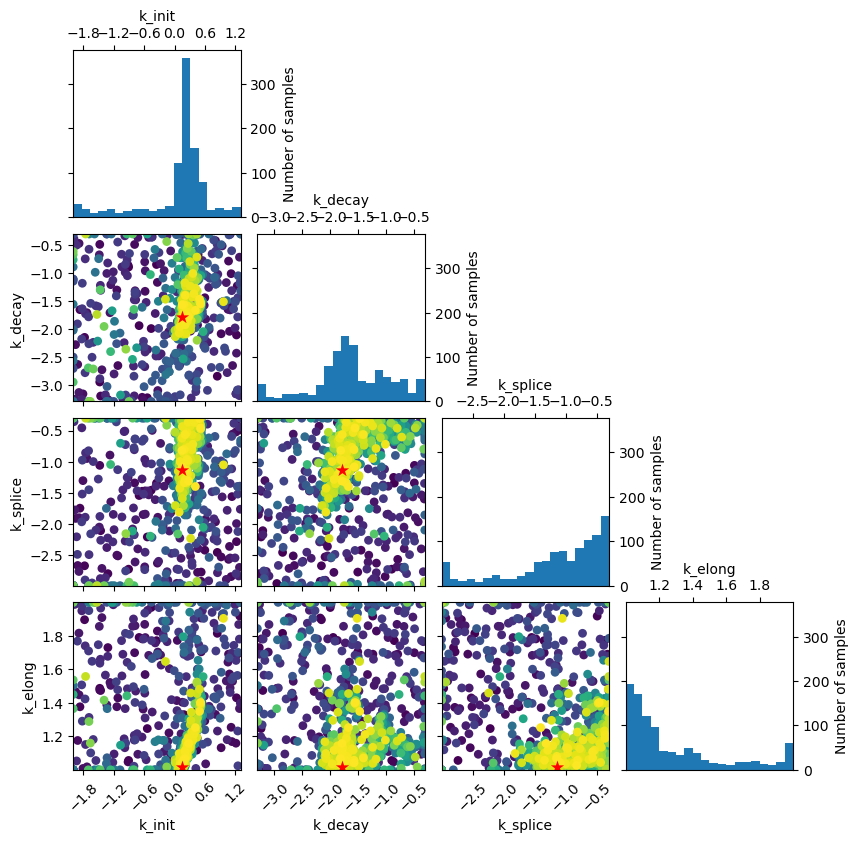

In [172]:
skopt.plots.plot_evaluations(res, dimensions=param_names)

array([[<AxesSubplot: xlabel='k_init', ylabel='Partial dependence'>,
        <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >],
       [<AxesSubplot: ylabel='k_decay'>,
        <AxesSubplot: xlabel='k_decay', ylabel='Partial dependence'>,
        <AxesSubplot: >, <AxesSubplot: >],
       [<AxesSubplot: ylabel='k_splice'>, <AxesSubplot: >,
        <AxesSubplot: xlabel='k_splice', ylabel='Partial dependence'>,
        <AxesSubplot: >],
       [<AxesSubplot: xlabel='k_init', ylabel='k_elong'>,
        <AxesSubplot: xlabel='k_decay'>,
        <AxesSubplot: xlabel='k_splice'>,
        <AxesSubplot: xlabel='k_elong', ylabel='Partial dependence'>]],
      dtype=object)

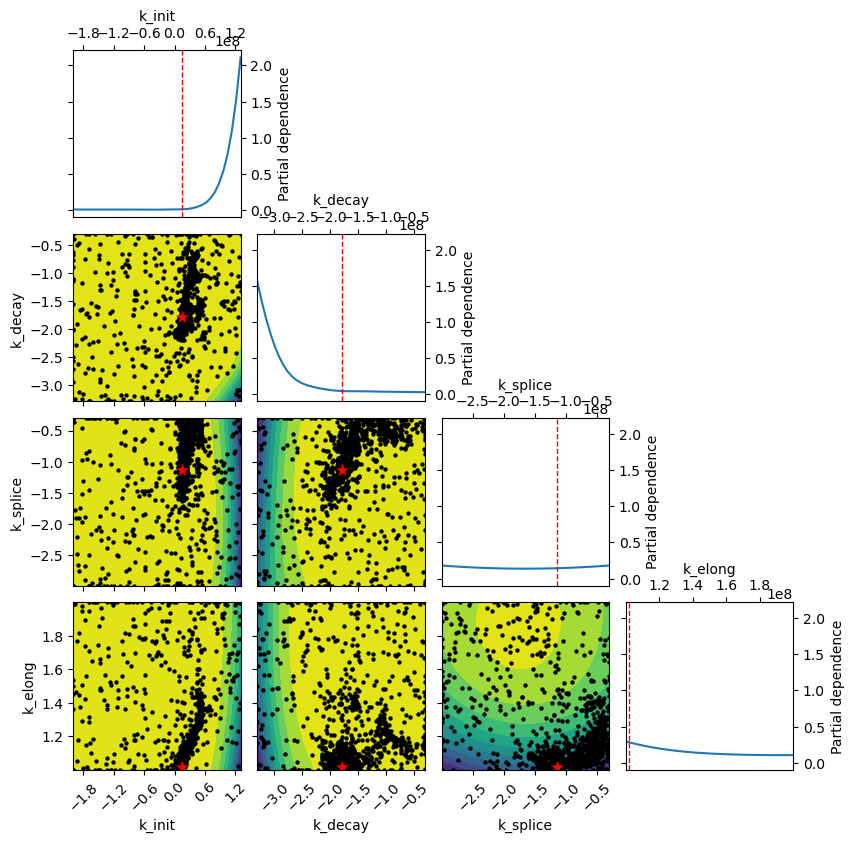

In [173]:
skopt.plots.plot_objective(res, dimensions=param_names)

In [233]:
np.array(res.x).reshape(1, -1)

array([[ 0.14295933, -1.7907947 , -1.13451116,  1.01861708]])

In [ ]:
fi

In [237]:
data = np.load(os.path.join(dir_data_aux, 'sim_bond_counts', 'mean-80.npy'))

In [241]:
data_time = time_steps - 1
data = data[data_time, :]

In [251]:
fitting.loss_sse(
            res.x,
            'count_per_splice_site',
            data_time,
            data,
            pos_intron,
            gene_length,
            n=25,
            kwargs=dict(log10=True, use_pool=False, use_tqdm=True))

  0%|          | 0/25 [00:00<?, ?it/s]

1302.584300000001

In [254]:
fitting.loss_sse(
            np.log10(params[index]),
            'count_per_splice_site',
            data_time,
            data,
            pos_intron,
            gene_length,
            n=25,
            kwargs=dict(log10=True, use_pool=False, use_tqdm=True))

  0%|          | 0/25 [00:00<?, ?it/s]

103.19549999999958

In [255]:
res.x_iters[np.argmin(res.func_vals)]

[0.1429593305096084,
 -1.7907946975118285,
 -1.1345111600968607,
 1.0186170832556467]

In [256]:
res.x

[0.1429593305096084,
 -1.7907946975118285,
 -1.1345111600968607,
 1.0186170832556467]

In [250]:
np.argmin(res.func_vals)

543

In [262]:
res.space

Space([Real(low=-2.0, high=1.3010299956639813, prior='uniform', transform='normalize'),
       Real(low=-3.3010299956639813, high=-0.3010299956639812, prior='uniform', transform='normalize'),
       Real(low=-3.0, high=-0.3010299956639812, prior='uniform', transform='normalize'),
       Real(low=1.0, high=2.0, prior='uniform', transform='normalize')])

In [258]:
res.models[0].predict(np.log10(params[index]).reshape(1, -1))

array([5.81412648e+09])

In [234]:
res.models[0].predict(np.array(res.x).reshape(1, -1))

array([9.83511503e+08])

In [259]:
pd.Series(res.func_vals).describe()

count    1.000000e+03
mean     6.452983e+06
std      7.155180e+07
min      1.604259e+02
25%      7.265015e+03
50%      2.334354e+04
75%      7.049959e+05
max      1.351676e+09
dtype: float64

In [269]:
import copy
import skopt.learning
import sklearn.gaussian_process.kernels

In [386]:
model = skopt.learning.GaussianProcessRegressor(sklearn.gaussian_process.kernels.Matern(1, nu=2.5), alpha=1)
# copy.deepcopy(res.models[0].kernel_)
model.fit(res.x_iters, res.func_vals)

GaussianProcessRegressor(alpha=1, kernel=Matern(length_scale=1, nu=2.5))

In [393]:
model.get_params()

{'alpha': 1,
 'copy_X_train': True,
 'kernel__length_scale': 1,
 'kernel__length_scale_bounds': (1e-05, 100000.0),
 'kernel__nu': 2.5,
 'kernel': Matern(length_scale=1, nu=2.5),
 'n_restarts_optimizer': 0,
 'noise': None,
 'normalize_y': False,
 'optimizer': 'fmin_l_bfgs_b',
 'random_state': None}

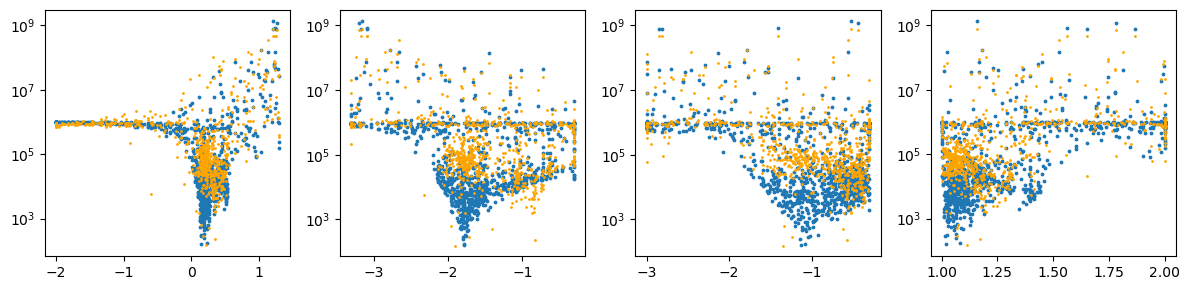

In [387]:
fig, axs = plt.subplots(1, 4, tight_layout=True, figsize=(12,3))
for i in range(4):
    axs[i].scatter(np.array(res.x_iters)[:,i], res.func_vals, s=3)
    axs[i].scatter(np.array(res.x_iters)[:,i], model.predict(np.array(res.x_iters)), c='orange', s=1)
    axs[i].set_yscale('log')
    # axs[i].scatter(np.array(res.x_iters)[:,i], res.models[0].predict(np.array(res.x_iters)), c='red', s=1, alpha=0.1)

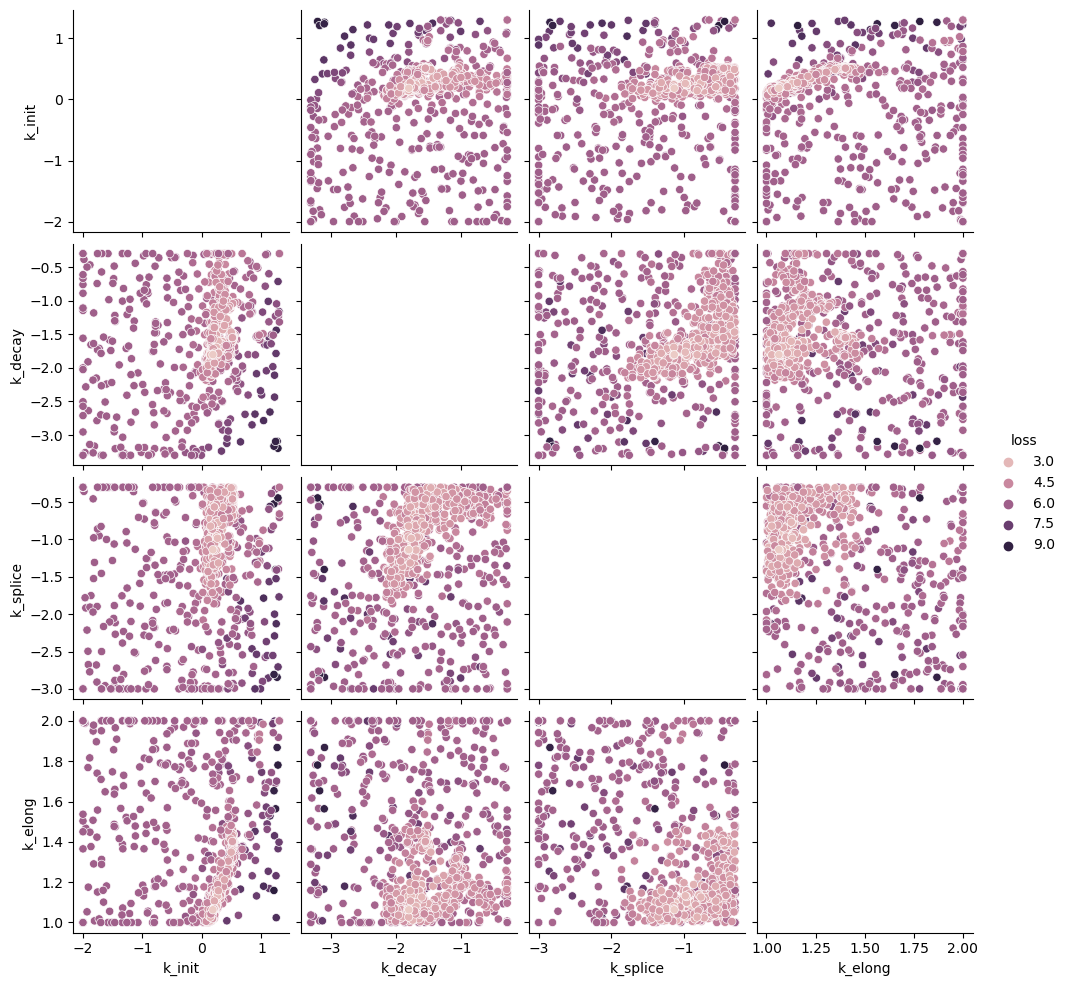

In [401]:
df = pd.DataFrame(res.x_iters)
df.columns = param_names
df['loss'] = np.log10(res.func_vals)
sns.pairplot(data=df, hue='loss')

In [ ]:
for i in range(4):
    for j in range(4):
        axs[i, j].

In [394]:
res.models[0].get_params()

{'alpha': 1e-10,
 'copy_X_train': True,
 'kernel__k1': 1**2 * Matern(length_scale=[1, 1, 1, 1], nu=2.5),
 'kernel__k2': WhiteKernel(noise_level=1),
 'kernel__k1__k1': 1**2,
 'kernel__k1__k2': Matern(length_scale=[1, 1, 1, 1], nu=2.5),
 'kernel__k1__k1__constant_value': 1.0,
 'kernel__k1__k1__constant_value_bounds': (0.01, 1000.0),
 'kernel__k1__k2__length_scale': array([1., 1., 1., 1.]),
 'kernel__k1__k2__length_scale_bounds': [(0.01, 100),
  (0.01, 100),
  (0.01, 100),
  (0.01, 100)],
 'kernel__k1__k2__nu': 2.5,
 'kernel__k2__noise_level': 1.0,
 'kernel__k2__noise_level_bounds': (1e-05, 100000.0),
 'kernel': 1**2 * Matern(length_scale=[1, 1, 1, 1], nu=2.5) + WhiteKernel(noise_level=1),
 'n_restarts_optimizer': 2,
 'noise': 'gaussian',
 'normalize_y': True,
 'optimizer': 'fmin_l_bfgs_b',
 'random_state': 822569775}

In [324]:
model.predict(np.array(res.x).reshape(1, -1))

array([154025.75066065])

## Junction Counts

In [29]:
rng = np.random.default_rng(0)

In [30]:
pos_exon_new = np.array([[1, 953], [827, 3640]])

In [31]:
x = (0.1, 0, 0, 50)

In [37]:
time_points, y = simulate.parallel_simulations(
    100,
    x,
    pos_intron[:, [0]],
    gene_length,
    1200,
    t_wash=600,
    stats_fun=stats_transcripts.junction_counts,
    stats_kwargs=dict(pos_exon=pos_exon_new, time_points=np.linspace(100, 1200, 5)),
    log10=False,
    alt_splicing=False,
    aggfun=simulate.mean,
    seed=0,
    verbose=True)

  0%|          | 0/100 [00:00<?, ?it/s]

In [22]:
time_points

array([ 100,  375,  650,  925, 1200])

In [38]:
y

array([[[15.87879081, 14.96752   ,  0.        ],
        [12.24273065,  0.        ,  0.        ]],

       [[43.88666264, 42.94136   ,  0.        ],
        [39.89617187,  0.        ,  0.        ]],

       [[67.01      , 67.01      ,  0.        ],
        [66.63528274,  0.        ,  0.        ]],

       [[67.01      , 67.01      ,  0.        ],
        [67.01      ,  0.        ,  0.        ]],

       [[67.01      , 67.01      ,  0.        ],
        [67.01      ,  0.        ,  0.        ]]])

In [50]:
res

  message: ABNORMAL_TERMINATION_IN_LNSRCH
  success: False
   status: 2
      fun: 26.63664310771593
        x: [ 1.000e-01  5.000e-05  2.500e-04  5.000e+01]
      nit: 0
      jac: [-6.740e+06 -8.997e+07  5.077e+05  1.258e+07]
     nfev: 105
     njev: 21
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>

In [51]:
x

(0.1, 0, 0, 50)

In [56]:
np.random.rand(1).item()

0.5966667422802707

In [57]:
x0 = np.array(x)
x0[0] = 0.01

In [59]:
res

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 196.64205161361042
        x: [ 1.000e-02  5.000e-05  2.500e-04  5.000e+01]
      nit: 0
      jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
     nfev: 5
     njev: 1
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>

In [61]:
x0

array([1.e-02, 0.e+00, 0.e+00, 5.e+01])

In [65]:
res

  message: ABNORMAL_TERMINATION_IN_LNSRCH
  success: False
   status: 2
      fun: 1.7158997606642896
        x: [ 1.007e-01  0.000e+00  0.000e+00  5.001e+01]
      nit: 4
      jac: [ 6.765e+02  1.928e+04  1.631e+04  8.809e-02]
     nfev: 380
     njev: 76
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>

In [64]:
res = scipy.optimize.minimize(
    fitting.loss,
    x0,
    args=('junction_counts',
          time_points,
          y,
          pos_intron[:, [0]],
          gene_length,
          'euclidean',
          32,
          int(1e9),
          None,
          dict(stats_kwargs=dict(pos_exon=pos_exon_new, time_points=time_points), seed=0),
          None),
    method='L-BFGS-B',
    bounds=np.array([(0.005, 20), (0, 0.2), (0, 1), (10, 100)]),
    options={'eps': 0.01},
    callback=lambda xk: fitting.callback_scipy(
        xk,
        'junction_counts',
          time_points,
          y,
          pos_intron[:, [0]],
          gene_length,
          'euclidean',
          32,
          int(1e9),
          None,
          dict(stats_kwargs=dict(pos_exon=pos_exon_new, time_points=time_points), seed=0),
          None,
        log10=False))

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Current parameters: [ 0.12765839  0.          0.         49.99994721]


  0%|          | 0/32 [00:00<?, ?it/s]

Current loss: 59.83182190737611
-----


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Current parameters: [ 0.10223301  0.          0.         49.99995224]


  0%|          | 0/32 [00:00<?, ?it/s]

Current loss: 2.138330141432952
-----


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Current parameters: [ 0.10070786  0.          0.         49.9999527 ]


  0%|          | 0/32 [00:00<?, ?it/s]

Current loss: 1.9516284918775801
-----


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Current parameters: [ 0.10067238  0.          0.         50.00868935]


  0%|          | 0/32 [00:00<?, ?it/s]

Current loss: 1.7158997606642896
-----


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

### Iterative Grid Search

In [8]:
df_jcs_igs = []
for index in range(n_param_values):
    file = os.path.join(dir_data_aux, 'sim_junction_counts', f'fit-igs-{index}.pkl')
    if os.path.exists(file):
        with open(file, 'rb') as f:
            res = pickle.load(f)
            df_jcs_igs.append(dict(
                index=index,
                x_fit=10**res['x'],
                loss=res['loss'],
                x_real=params[index]))
    else:
        print(f'{file} does not exist')
df_jcs_igs = pd.DataFrame(df_jcs_igs)

In [9]:
len(df_jcs_igs['index'].unique())

81

In [10]:
df_jcs_igs['param_diff_log10'] = np.abs(df_jcs_igs['x_fit'].map(np.log10) - df_jcs_igs['x_real'].map(np.log10)).map(np.sum)

In [11]:
for i, name in enumerate(param_names):
    df_jcs_igs[name + '_fit'] = df_jcs_igs['x_fit'].map(lambda x: x[i])
    df_jcs_igs[name] = df_jcs_igs['x_real'].map(lambda x: x[i])

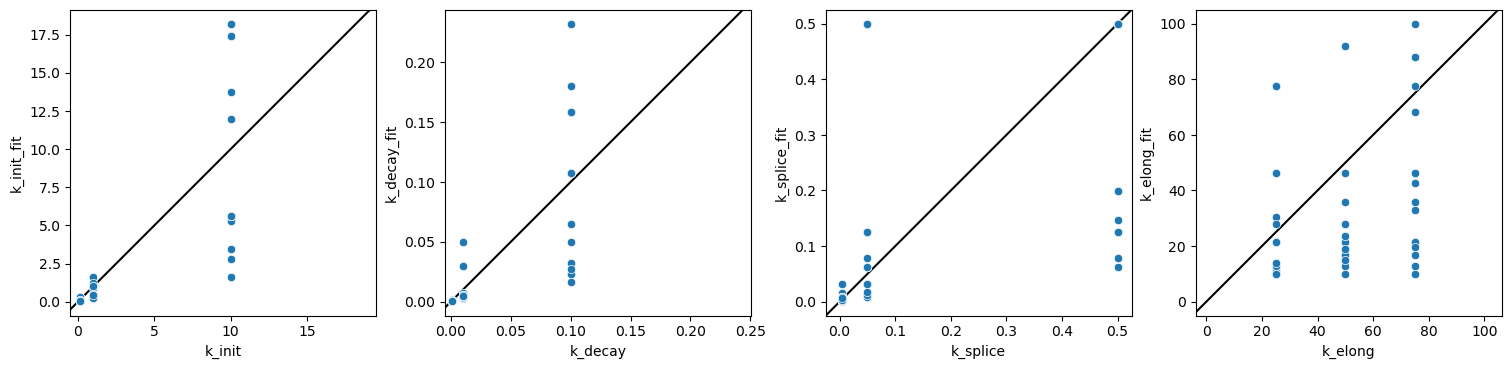

In [12]:
fig, axs = plt.subplots(1, n_params, figsize=(15, 5), constrained_layout=True)
for i, name in enumerate(param_names):
    sns.scatterplot(data=df_jcs_igs, x=name, y=name + '_fit', ax=axs[i])
    axs[i].axline((0, 0), slope=1, color='black', zorder=0)
    axs[i].axis('square')

count    8.100000e+01
mean     2.220644e+06
std      6.294636e+06
min      1.881966e-01
25%      4.291884e+01
50%      2.438521e+03
75%      1.604350e+05
max      2.750179e+07
Name: loss, dtype: float64

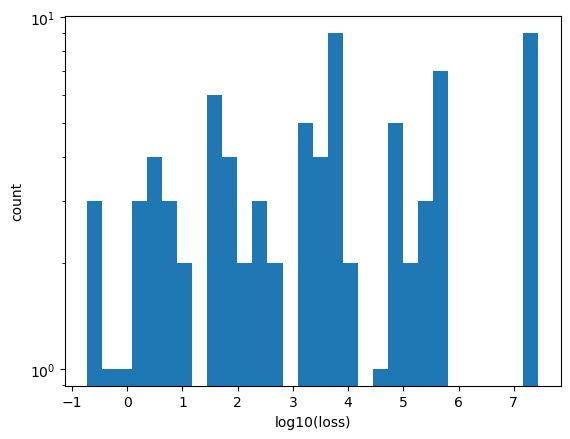

In [13]:
fig, ax = plt.subplots()
ax.hist(np.log10(df_jcs_igs['loss']), bins=30, log=True)
ax.set(xlabel='log10(loss)', ylabel='count')
df_jcs_igs['loss'].describe()

### L-BFGS-B

In [14]:
df_jcs_lbfgsb = []
for index in range(n_param_values):
    file = os.path.join(dir_data_aux, 'sim_bond_counts', f'fit-lbfgsb-{index}.pkl')
    if os.path.exists(file):
        with open(file, 'rb') as f:
            res = pickle.load(f)
            del res['hess_inv'], res['jac']
            res.update(dict(index=index, x_real=params[index]))
            df_jcs_lbfgsb.append(dict(res))
    else:
        print(f'{file} does not exist')
df_jcs_lbfgsb = pd.DataFrame(df_jcs_lbfgsb).rename(columns=dict(x='x_fit', fun='loss'))
df_jcs_lbfgsb['x_fit'] = df_jcs_lbfgsb['x_fit'].map(lambda x: 10**x)

In [15]:
len(df_jcs_lbfgsb['index'].unique())

81

In [16]:
for col in ['nfev', 'nit', 'status', 'message', 'success']:
    display(df_jcs_lbfgsb[col].value_counts())
    print()

125    6
30     5
90     5
150    4
80     4
130    4
105    4
135    3
155    3
55     3
120    3
145    3
100    3
170    3
115    3
50     2
35     2
140    2
70     2
60     2
75     2
40     1
110    1
160    1
220    1
260    1
255    1
175    1
85     1
95     1
225    1
190    1
45     1
215    1
Name: nfev, dtype: int64

5     15
6     13
2     12
7     11
4     10
8      6
9      5
3      4
10     3
12     2
Name: nit, dtype: int64

0    81
Name: status, dtype: int64

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH    81
Name: message, dtype: int64

True    81
Name: success, dtype: int64

In [17]:
for i, name in enumerate(param_names):
    df_jcs_lbfgsb[name + '_fit'] = df_jcs_lbfgsb['x_fit'].map(lambda x: x[i])
    df_jcs_lbfgsb[name] = df_jcs_lbfgsb['x_real'].map(lambda x: x[i])

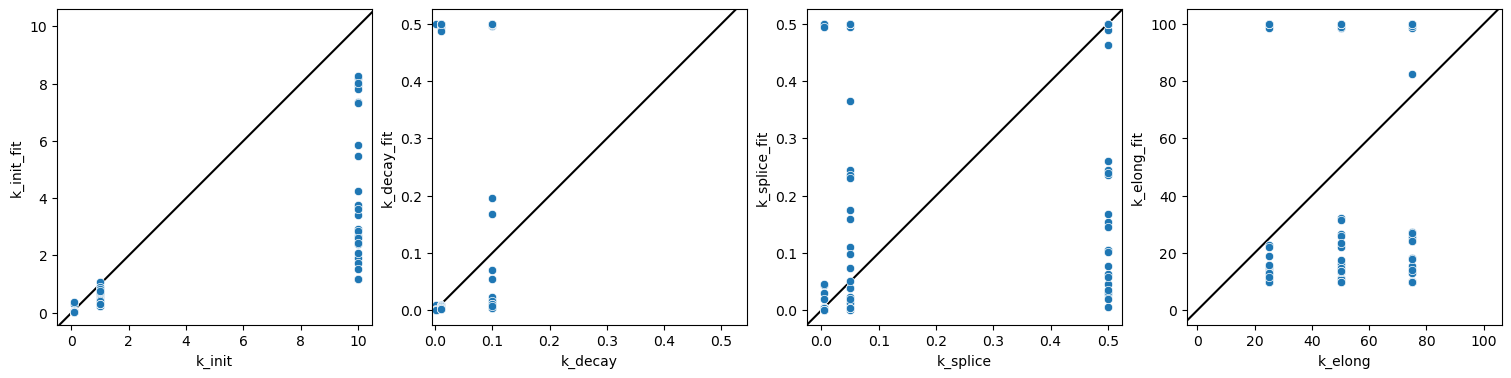

In [18]:
fig, axs = plt.subplots(1, n_params, figsize=(15, 5), constrained_layout=True)
for i, name in enumerate(param_names):
    sns.scatterplot(data=df_jcs_lbfgsb, x=name, y=name + '_fit', ax=axs[i])
    axs[i].axline((0, 0), slope=1, color='black', zorder=0)
    axs[i].axis('square')

count    8.100000e+01
mean     1.027527e+06
std      3.422499e+06
min      8.250600e+01
25%      8.248058e+02
50%      3.223099e+03
75%      3.170169e+05
max      2.583130e+07
Name: loss, dtype: float64

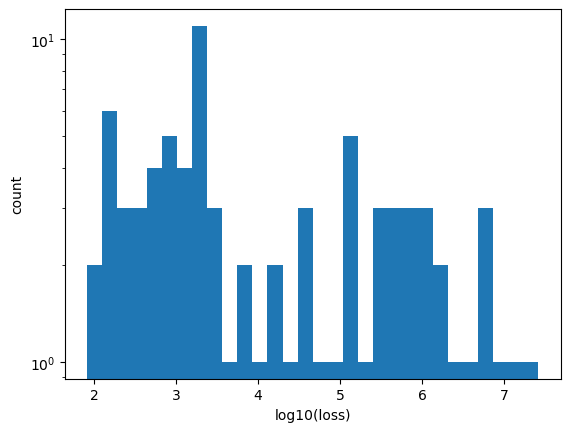

In [19]:
fig, ax = plt.subplots()
ax.hist(np.log10(df_jcs_lbfgsb['loss']), bins=30, log=True)
ax.set(xlabel='log10(loss)', ylabel='count')
df_jcs_lbfgsb['loss'].describe()

#### Dissecting a specific fit

Based on index 0

In [53]:
with pd.option_context('display.max_colwidth', 100, 'display.precision', 4):
    display(df_jcs_lbfgsb.iloc[0])

loss                                                                                       3223.0995
nfev                                                                                             120
njev                                                                                              24
nit                                                                                                6
status                                                                                             0
message                                              CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
x_fit           [0.0527134157141989, 0.0005968224783875482, 0.04441795027143762, 13.389069467155943]
success                                                                                         True
index                                                                                              0
x_real                                                                     [0.1, 0.001, 0.0

In [59]:
_, junction_counts_fit = simulate.parallel_simulations(
    100,
    df_jcs_lbfgsb.iloc[0]['x_fit'],
    pos_intron,
    gene_length,
    n_time_steps,
    use_pool=True,
    use_tqdm=True,
    aggfun=simulate.mean,
    alt_splicing=False,
    stats_fun=stats_transcripts.junction_counts,
    stats_kwargs=dict(time_steps=time_steps-1, pos_exon=pos_exon))

  0%|          | 0/100 [00:00<?, ?it/s]

In [60]:
junction_counts_orig = np.load(os.path.join(dir_data_aux, 'sim_junction_counts', 'mean-0.npy'))

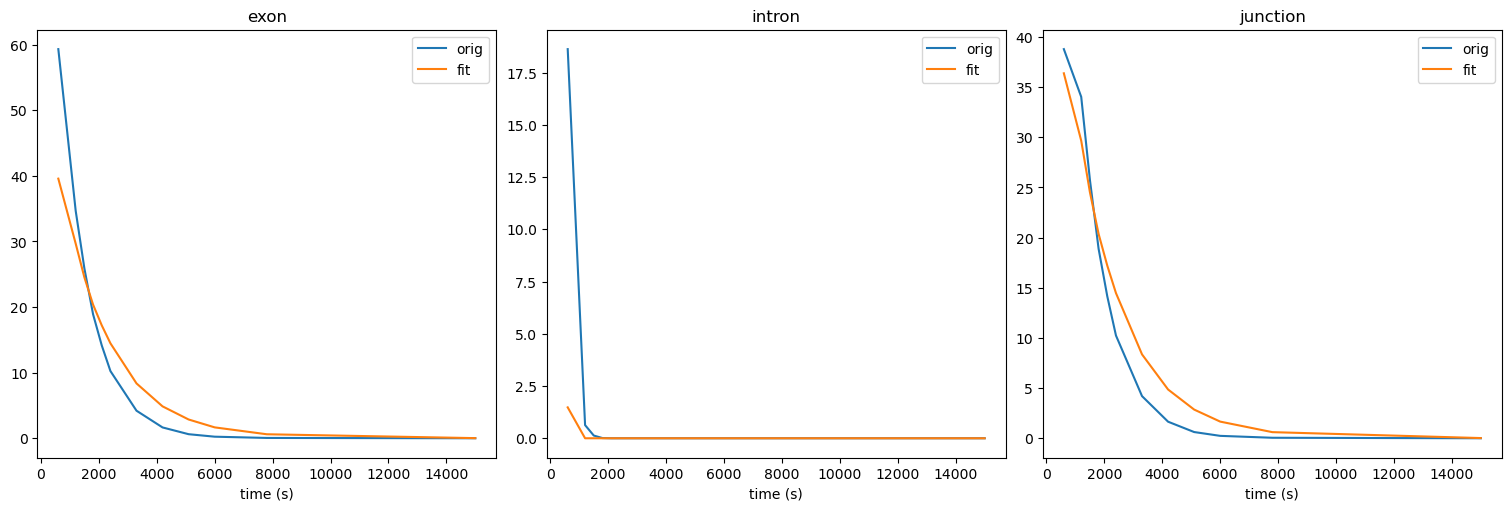

In [69]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)
feature_order = ('exon', 'intron', 'junction')
for i in range(3):
    axs[i].plot(time_steps,junction_counts_orig[data_time, 0, i], label='orig')
    axs[i].plot(time_steps,junction_counts_fit[:, 0, i], label='fit')
    axs[i].legend()
    axs[i].set_xlabel('time (s)')
    axs[i].set_title(feature_order[i])

##### Loss landscape

In [ ]:
x_fit = df_jcs_lbfgsb.iloc[0]['x_fit']
for 

In [74]:
fitting.loss_sse(
    df_jcs_lbfgsb.iloc[0]['x_fit'],
    'junction_counts',
    data_time,
    junction_counts_orig[data_time],
    pos_intron,
    gene_length,
    n=10,
    kwargs=dict(
        use_pool=True,
        use_tqdm=True,
        aggfun=simulate.mean,
        alt_splicing=False,
        stats_kwargs=dict(time_steps=time_steps-1, pos_exon=pos_exon)))

  0%|          | 0/10 [00:00<?, ?it/s]

4657.45478134789

### Gaussian Processes

In [20]:
df_jcs_gp = []
for index in tqdm(range(n_param_values)):
    file = os.path.join(dir_data_aux, 'sim_bond_counts', f'fit-gp-{index}.pkl.gz')
    if os.path.exists(file):
        res = skopt.load(file)
        res.update(dict(index=index, x_real=params[index]))
        df_jcs_gp.append(dict(res))
    else:
        print(f'{file} does not exist')
df_jcs_gp = pd.DataFrame(df_jcs_gp).rename(columns=dict(x='x_fit', fun='loss'))
df_jcs_gp['x_fit'] = df_jcs_gp['x_fit'].map(lambda x: 10**np.array(x))

  0%|          | 0/81 [00:00<?, ?it/s]

In [21]:
len(df_jcs_gp['index'].unique())

81

In [22]:
for i, name in enumerate(param_names):
    df_jcs_gp[name + '_fit'] = df_jcs_gp['x_fit'].map(lambda x: x[i])
    df_jcs_gp[name] = df_jcs_gp['x_real'].map(lambda x: x[i])

Text(0.5, 0.98, 'Gaussian Process Fit of Bond Counts')

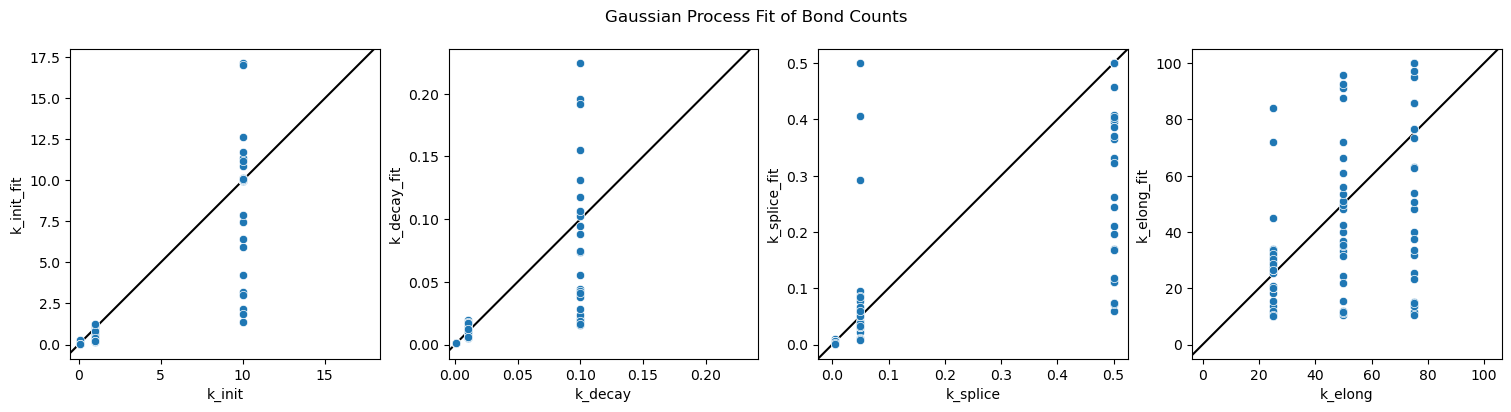

In [23]:
fig, axs = plt.subplots(1, n_params, figsize=(15, 4), constrained_layout=True)
for i, name in enumerate(param_names):
    sns.scatterplot(data=df_jcs_gp, x=name, y=name + '_fit', ax=axs[i])
    axs[i].axline((0, 0), slope=1, color='black', zorder=0)
    axs[i].axis('square')
fig.suptitle('Gaussian Process Fit of Bond Counts')

In [24]:
df_jcs_gp_long = df_jcs_gp.drop(columns=['func_vals', 'x_iters', 'models', 'x_fit', 'space', 'random_state', 'specs', 'x_real'])
df_jcs_gp_long = df_jcs_gp_long \
    .melt(
        id_vars=df_jcs_gp_long.columns[~df_jcs_gp_long.columns.isin(param_names)],
        value_vars=param_names,
        var_name='parameter',
        value_name='actual') \
    .rename(columns=lambda s: '_'.join(s.split('_')[:2])) \
    .melt(
        id_vars=['loss', 'index', 'parameter', 'actual'],
        value_vars=param_names,
        var_name='parameter2',
        value_name='fit') \
    .pipe(lambda df: df.loc[df['parameter'] == df['parameter2']]) \
    .drop(columns=['parameter2'])
df_jcs_gp_long['rank'] = df_jcs_gp_long.groupby(['parameter'])['actual'].rank(method='dense')

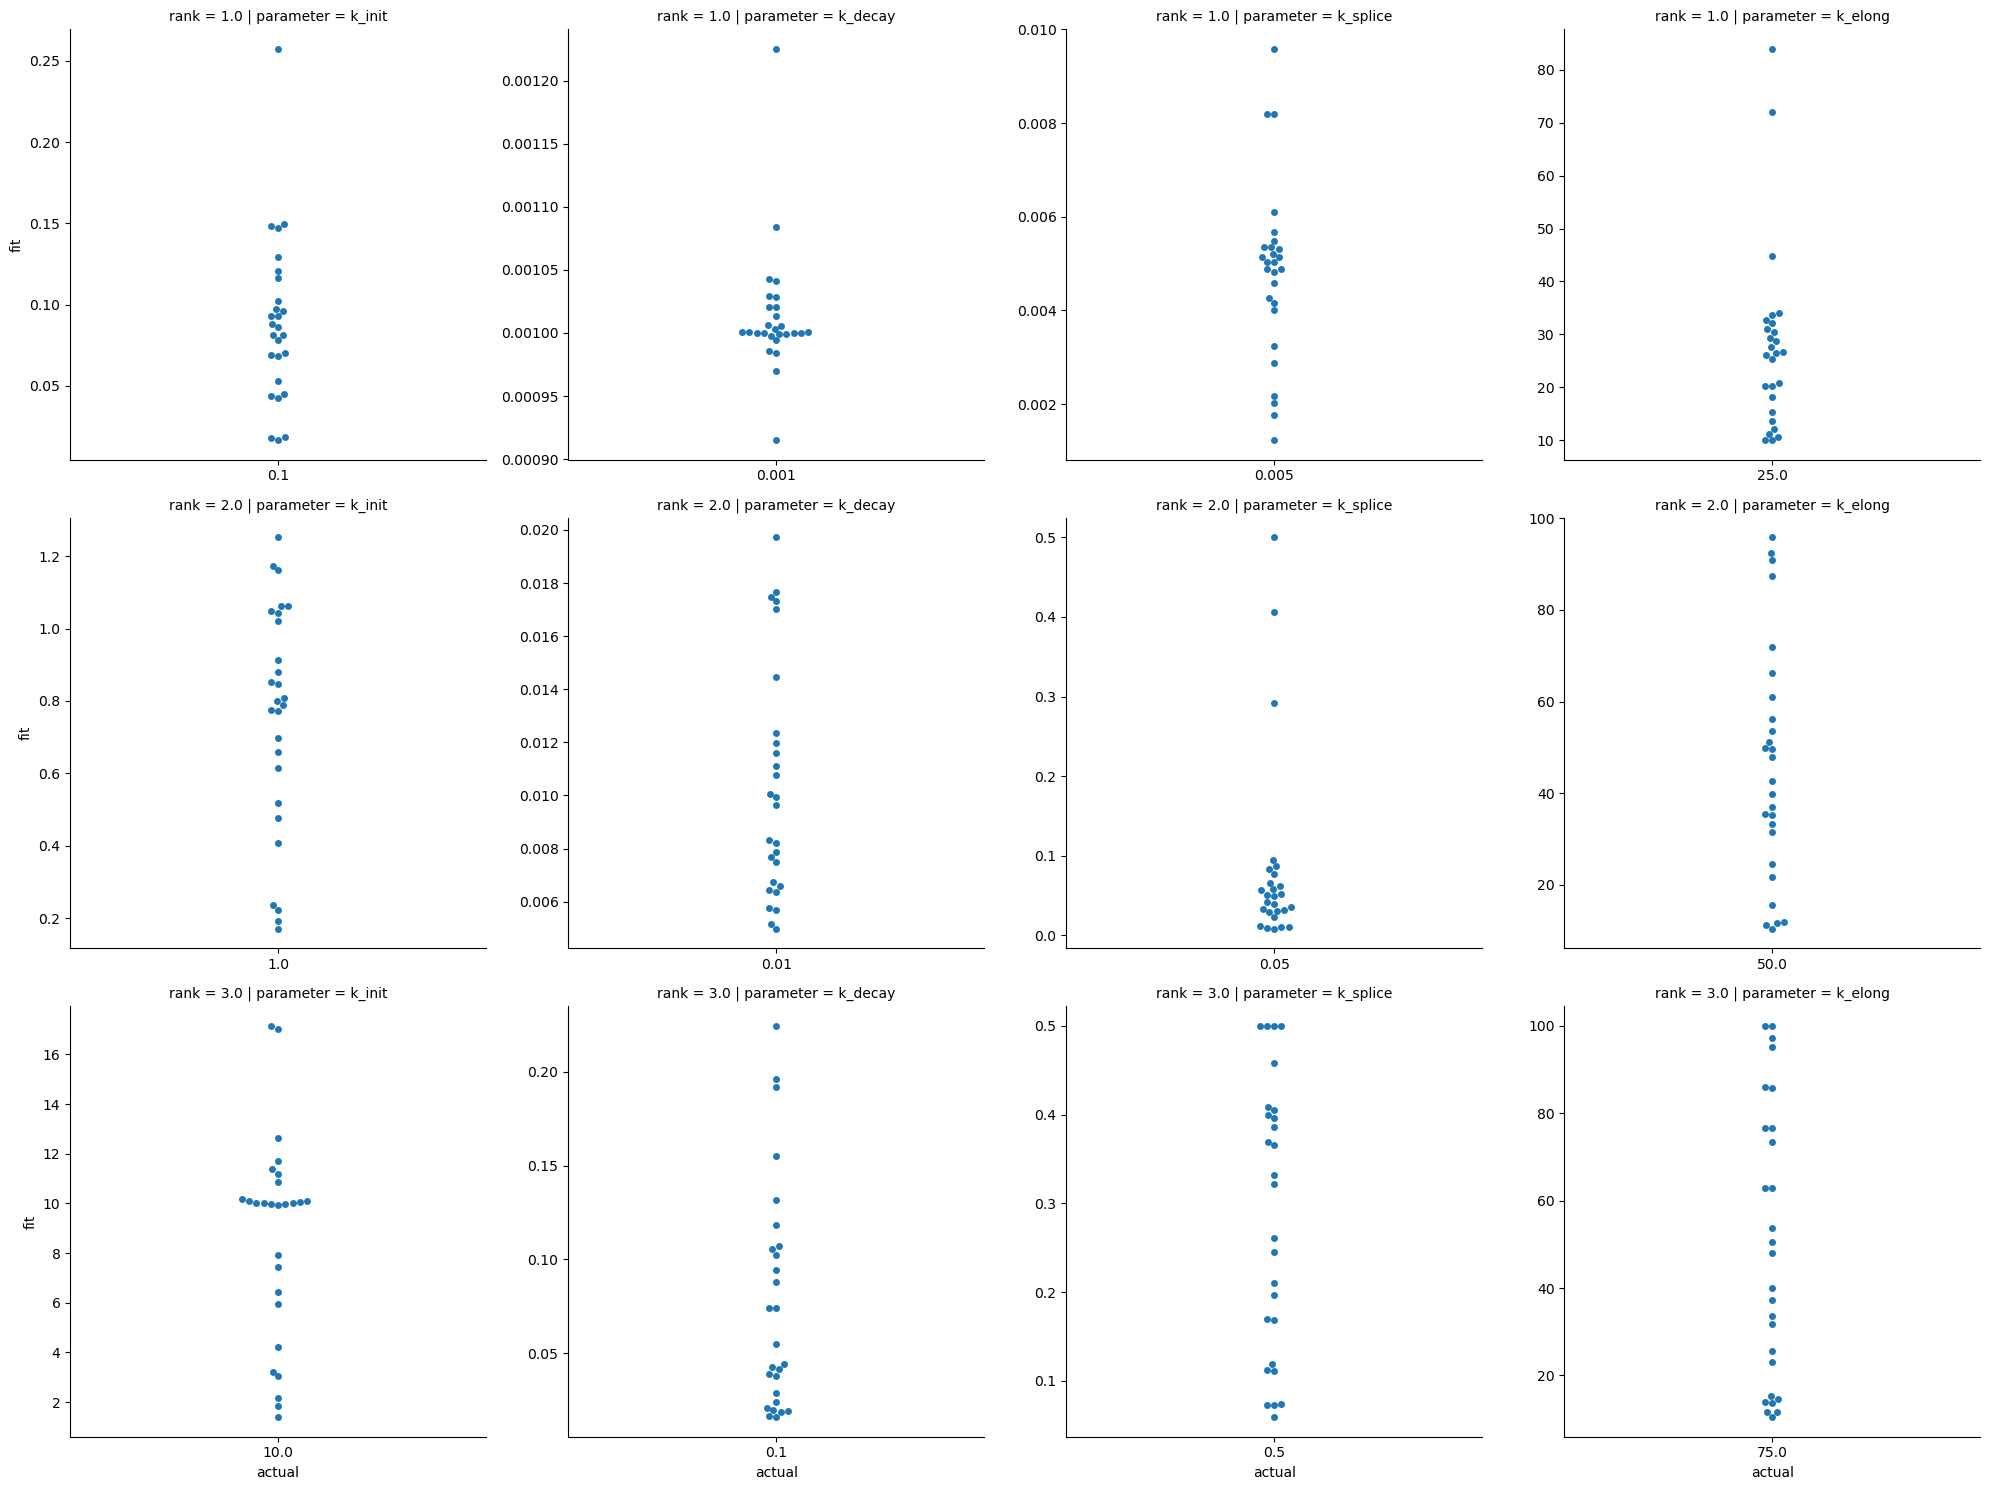

In [25]:
sns.catplot(
    kind='swarm',
    data=df_jcs_gp_long,
    x='actual',
    y='fit',
    col='parameter',
    row='rank',
    sharex=False,
    sharey=False)

count    8.100000e+01
mean     2.566342e+04
std      2.116425e+05
min      3.520000e-01
25%      1.614870e+01
50%      1.992353e+02
75%      1.015024e+03
max      1.906105e+06
Name: loss, dtype: float64

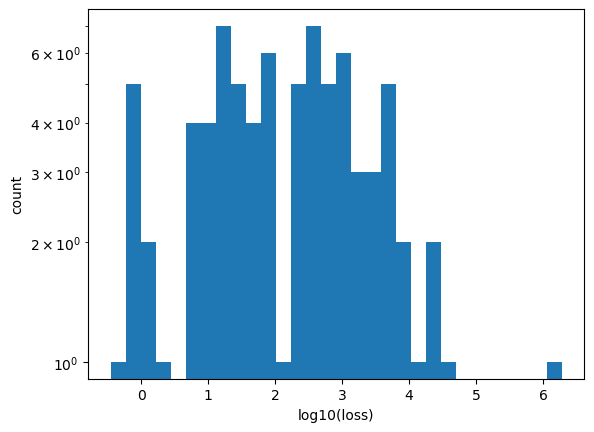

In [26]:
fig, ax = plt.subplots()
ax.hist(np.log10(df_jcs_gp['loss']), bins=30, log=True)
ax.set(xlabel='log10(loss)', ylabel='count')
df_jcs_gp['loss'].describe()

# Interactive

In [91]:
# res = skopt.load(os.path.join(dir_data_aux, 'sim_spliced_fraction', 'fit-gp-1.pkl.gz'))


In [94]:
res = skopt.load('../scripts/tmp.pkl.gz')

In [97]:
res

          fun: 16114.9967
    func_vals: array([1.61149967e+04, 3.56481352e+09, 2.07592057e+05])
       models: [GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1, 1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, random_state=822569775)]
 random_state: RandomState(MT19937) at 0x7F38F87AB440
        space: Space([Real(low=-2.0, high=1.3010299956639813, prior='uniform', transform='normalize'),
       Real(low=-3.3010299956639813, high=-0.3010299956639812, prior='uniform', transform='normalize'),
       Real(low=-3.0, high=-0.3010299956639812, prior='uniform', transform='normalize'),
       Real(low=1.0, high=2.0, prior='uniform', transform='normalize')])
        specs: {'args': {'dimensions': Space([Real(low=-2.0, high=1.3010299956639813, prior='uniform', transform='normalize'),
       Real(low=-3.3010299956639813, high=-0.3010299956639812, prior='uniform', transform='

array([[<AxesSubplot: xlabel='$X_{0}$', ylabel='Partial dependence'>,
        <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >],
       [<AxesSubplot: ylabel='$X_{1}$'>,
        <AxesSubplot: xlabel='$X_{1}$', ylabel='Partial dependence'>,
        <AxesSubplot: >, <AxesSubplot: >],
       [<AxesSubplot: ylabel='$X_{2}$'>, <AxesSubplot: >,
        <AxesSubplot: xlabel='$X_{2}$', ylabel='Partial dependence'>,
        <AxesSubplot: >],
       [<AxesSubplot: xlabel='$X_{0}$', ylabel='$X_{3}$'>,
        <AxesSubplot: xlabel='$X_{1}$'>, <AxesSubplot: xlabel='$X_{2}$'>,
        <AxesSubplot: xlabel='$X_{3}$', ylabel='Partial dependence'>]],
      dtype=object)

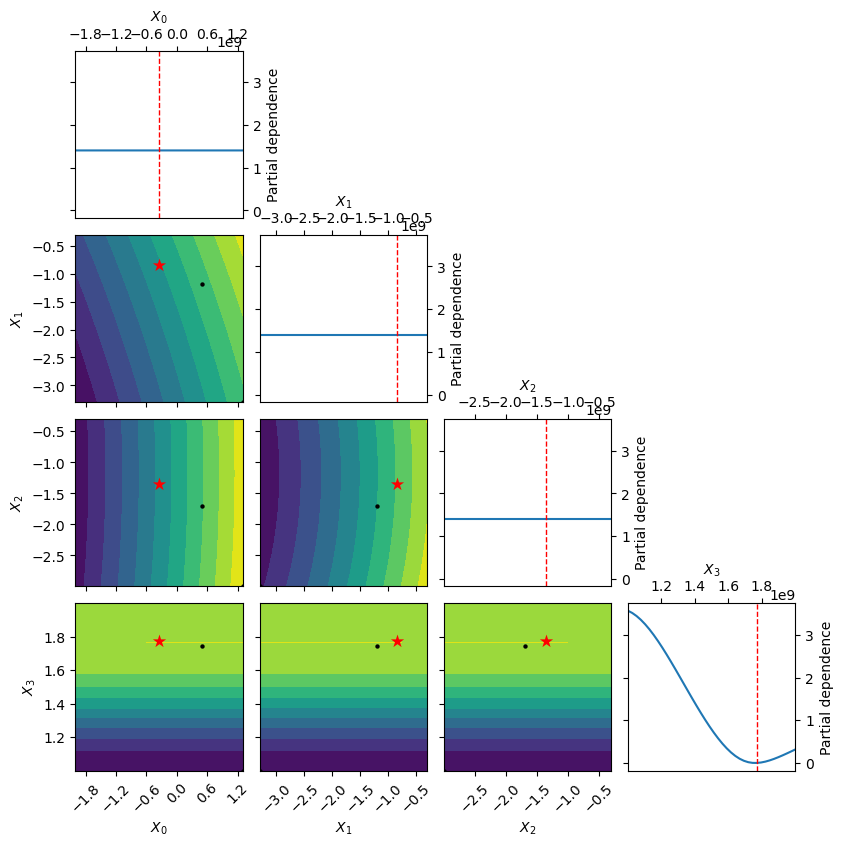

In [95]:
skopt.plots.plot_objective(res)

array([[<AxesSubplot: xlabel='$X_{0}$', ylabel='Number of samples'>,
        <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >],
       [<AxesSubplot: ylabel='$X_{1}$'>,
        <AxesSubplot: xlabel='$X_{1}$', ylabel='Number of samples'>,
        <AxesSubplot: >, <AxesSubplot: >],
       [<AxesSubplot: ylabel='$X_{2}$'>, <AxesSubplot: >,
        <AxesSubplot: xlabel='$X_{2}$', ylabel='Number of samples'>,
        <AxesSubplot: >],
       [<AxesSubplot: xlabel='$X_{0}$', ylabel='$X_{3}$'>,
        <AxesSubplot: xlabel='$X_{1}$'>, <AxesSubplot: xlabel='$X_{2}$'>,
        <AxesSubplot: xlabel='$X_{3}$', ylabel='Number of samples'>]],
      dtype=object)

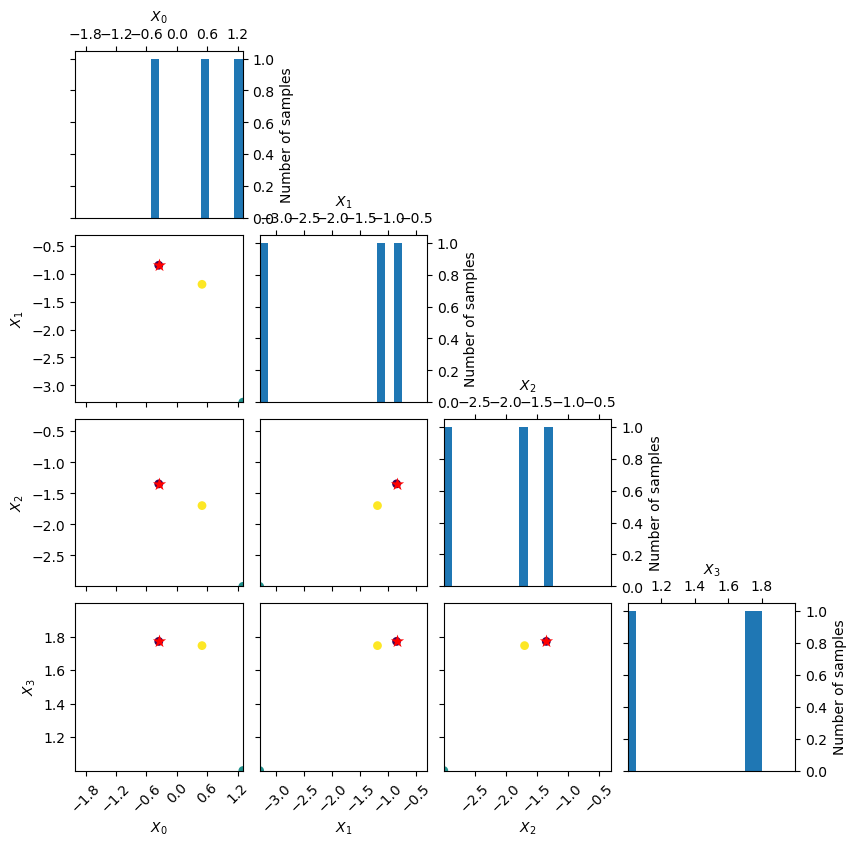

In [96]:
skopt.plots.plot_evaluations(res)

In [7]:
sys.path.append(dir_scripts)
import fitting_sfs_gp

In [48]:
res = fitting_sfs_gp.main(1, 0, 100, 5)

Iteration No: 1 started. Evaluating function at random point.
Current parameters: [4.39341968e-01 1.42064422e-01 4.48819423e-02 5.90690408e+01]
Current loss: 2.543548391658552
Best parameters: [4.39341968e-01 1.42064422e-01 4.48819423e-02 5.90690408e+01]
Best loss: 2.543548391658552
-----
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0054
Function value obtained: 2.5435
Current minimum: 2.5435
Iteration No: 2 started. Evaluating function at random point.
Current parameters: [6.93580272e+00 1.41540557e-03 3.43396746e-03 6.53375633e+01]
Current loss: 4.684318750728076
Best parameters: [4.39341968e-01 1.42064422e-01 4.48819423e-02 5.90690408e+01]
Best loss: 2.543548391658552
-----
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0052
Function value obtained: 4.6843
Current minimum: 2.5435
Iteration No: 3 started. Evaluating function at random point.
Current parameters: [3.34390742e-02 1.11527890e-03 1.08352027e-03 3.06784521e+01]
Current loss: 

/central/groups/guttman/btyeh/splicing-kinetics/modules/stats_transcripts.py:113: RuntimeWarning: invalid value encountered in divide
  stats[t] = np.nansum(transcripts[:, :-1] == -1, axis=0) / \


Current parameters: [1.e-02 5.e-04 5.e-01 1.e+01]
Current loss: 3.1354601805043227
Best parameters: [4.39341968e-01 1.42064422e-01 4.48819423e-02 5.90690408e+01]
Best loss: 2.543548391658552
-----
Iteration No: 6 ended. Search finished for the next optimal point.
Time taken: 0.4629
Function value obtained: 3.1355
Current minimum: 2.5435
Iteration No: 7 started. Searching for the next optimal point.
Current parameters: [ 1.03957663  0.5         0.04558529 10.        ]
Current loss: 2.482535143045114
Best parameters: [ 1.03957663  0.5         0.04558529 10.        ]
Best loss: 2.482535143045114
-----
Iteration No: 7 ended. Search finished for the next optimal point.
Time taken: 0.6018
Function value obtained: 2.4825
Current minimum: 2.4825
Iteration No: 8 started. Searching for the next optimal point.
Current parameters: [2.00000000e+01 8.80636704e-04 6.57059030e-02 1.05503475e+01]
Current loss: 2.4399773520747137
Best parameters: [2.00000000e+01 8.80636704e-04 6.57059030e-02 1.05503475e

/central/groups/guttman/btyeh/splicing-kinetics/modules/stats_transcripts.py:113: RuntimeWarning: invalid value encountered in divide
  stats[t] = np.nansum(transcripts[:, :-1] == -1, axis=0) / \


Current parameters: [1.00000000e-02 5.00000000e-04 9.88100218e-02 1.00000000e+01]
Current loss: 3.1354601805043227
Best parameters: [2.00000000e+01 6.53241572e-04 9.88320982e-02 8.23976204e+01]
Best loss: 1.85467305773412
-----
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 0.5713
Function value obtained: 3.1355
Current minimum: 1.8547
Iteration No: 16 started. Searching for the next optimal point.
Current parameters: [2.00000000e+01 5.00000000e-04 8.43497602e-02 8.04840142e+01]
Current loss: 1.8276461798251218
Best parameters: [2.00000000e+01 5.00000000e-04 8.43497602e-02 8.04840142e+01]
Best loss: 1.8276461798251218
-----
Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 0.7089
Function value obtained: 1.8276
Current minimum: 1.8276
Iteration No: 17 started. Searching for the next optimal point.
Current parameters: [2.00000000e+01 5.00000000e-04 7.33678615e-02 8.38533775e+01]
Current loss: 1.8426423030737002
Best paramete

/central/groups/guttman/btyeh/splicing-kinetics/modules/stats_transcripts.py:113: RuntimeWarning: invalid value encountered in divide
  stats[t] = np.nansum(transcripts[:, :-1] == -1, axis=0) / \


Current parameters: [1.00000000e-02 5.00000000e-04 2.26246415e-02 1.00000000e+01]
Current loss: 3.4595792281233706
Best parameters: [2.00000000e+01 5.00000000e-04 9.93056961e-02 1.00000000e+02]
Best loss: 1.7591048003187255
-----
Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.4858
Function value obtained: 3.4596
Current minimum: 1.7591
Iteration No: 30 started. Searching for the next optimal point.


/central/groups/guttman/btyeh/splicing-kinetics/modules/stats_transcripts.py:113: RuntimeWarning: invalid value encountered in divide
  stats[t] = np.nansum(transcripts[:, :-1] == -1, axis=0) / \


Current parameters: [1.00000000e-02 5.00000000e-04 6.52229316e-02 1.00000000e+02]
Current loss: 3.1354601805043227
Best parameters: [2.00000000e+01 5.00000000e-04 9.93056961e-02 1.00000000e+02]
Best loss: 1.7591048003187255
-----
Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.5443
Function value obtained: 3.1355
Current minimum: 1.7591
Iteration No: 31 started. Searching for the next optimal point.
Current parameters: [1.12027206e+01 5.00000000e-04 9.48666624e-02 1.00000000e+02]
Current loss: 1.7357020533900325
Best parameters: [1.12027206e+01 5.00000000e-04 9.48666624e-02 1.00000000e+02]
Best loss: 1.7357020533900325
-----
Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 0.5022
Function value obtained: 1.7357
Current minimum: 1.7357
Iteration No: 32 started. Searching for the next optimal point.
Current parameters: [2.53360956e+00 5.00000000e-04 4.91675052e-02 2.90085644e+01]
Current loss: 2.0151587460075957
Best parame

In [49]:
f = open('tmp.pkl', 'wb')
pickle.dump(res, f)
f.close()
f = open('tmp.pkl', 'rb')
res2 = pickle.load(f)
f.close()

In [50]:
res2

          fun: 1.6809832740654556
    func_vals: array([2.54354839, 4.68431875, 5.2307663 , 4.18258818, 3.37650877,
       3.13546018, 2.48253514, 2.43997735, 2.45237411, 2.02418679,
       3.68712685, 1.88026957, 1.86490219, 1.85467306, 3.13546018,
       1.82764618, 1.8426423 , 2.15929284, 1.8492682 , 2.25415163,
       2.93090651, 1.90856985, 2.03363346, 2.22850409, 1.80335478,
       2.18461991, 1.7591048 , 1.82779564, 3.45957923, 3.13546018,
       1.73570205, 2.01515875, 1.748049  , 1.86480584, 1.7673454 ,
       1.80097   , 1.75402497, 1.80334346, 1.79214297, 1.81081403,
       1.78853899, 1.79397177, 1.85976831, 1.83429417, 1.68098327,
       1.79520373, 1.81498844, 1.82163988, 1.75422792, 1.80036356,
       1.76276624, 1.83739319, 1.81258786, 1.78064966, 1.79695018,
       1.75605909, 1.79207445, 1.85704862, 1.76236225, 1.74457386,
       1.74228117, 1.76163353, 1.69224476, 1.74657471, 1.87555968,
       1.8073574 , 1.89357706, 1.72900274, 1.78088003, 1.81745456,
       1.7225

In [51]:
import gzip
with gzip.open('tmp.pkl.gz', 'wb') as f:
    pickle.dump(res, f)

In [55]:
import gc
def actualsize(input_obj):
    memory_size = 0
    ids = set()
    objects = [input_obj]
    while objects:
        new = []
        for obj in objects:
            if id(obj) not in ids:
                ids.add(id(obj))
                memory_size += sys.getsizeof(obj)
                new.append(obj)
        objects = gc.get_referents(*new)
    return memory_size

In [64]:
{k: actualsize(v) for k, v in res2.items()}

{'x': 184, 'fun': 32, 'func_vals': 912, 'x_iters': 19320, 'random_state': 6642}

In [59]:
import copy
res2 = copy.deepcopy(res)

In [62]:
res2.pop('models')
res2.pop('space')
res2.pop('specs')

{'args': {'func': <function fitting_sfs_gp.loss(x)>,
  'dimensions': Space([Real(low=-2.0, high=1.3010299956639813, prior='uniform', transform='normalize'),
         Real(low=-3.3010299956639813, high=-0.3010299956639812, prior='uniform', transform='normalize'),
         Real(low=-3.0, high=-0.3010299956639812, prior='uniform', transform='normalize'),
         Real(low=1.0, high=2.0, prior='uniform', transform='normalize')]),
  'base_estimator': GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1, 1, 1], nu=2.5),
                           n_restarts_optimizer=2, noise='gaussian',
                           normalize_y=True, random_state=822569775),
  'n_calls': 100,
  'n_random_starts': None,
  'n_initial_points': 5,
  'initial_point_generator': 'random',
  'acq_func': 'gp_hedge',
  'acq_optimizer': 'auto',
  'x0': None,
  'y0': None,
  'random_state': RandomState(MT19937) at 0x7F39080B6640,
  'verbose': True,
  'callback': <function fitting_sfs_gp.callback(res)>,
  'n_po

In [70]:
actualsize(res['space'])

122927433

In [66]:
res3 = {k: res2[k] for k in res2.keys()}

In [65]:
actualsize(res2)

122912889

In [6]:
mean_fillna0 = np.load(os.path.join(dir_data_aux, 'sim_spliced_fraction', 'mean_fillna-0.npy'))
data = mean_fillna0[time_steps - 1, :]
data_time = time_steps - 1

In [7]:
warnings.simplefilter('ignore', RuntimeWarning)

In [16]:
# model parameters - initial guesses
k_init_0 = 0.2  # mRNA / second
k_decay_0 = 0.005 # mRNA / second
k_splice_0 = 0.01 # 1 / second
k_elong_0 = 30       # nt / second

x0 = (k_init_0, k_decay_0, k_splice_0, k_elong_0)
bounds = [(0.01, 1), (1e-3, 0.1), (1e-3, 0.1), (10, 50)]
bounds_np = np.array(bounds)

In [15]:
print('Target:', params[0])
print('Optimal loss:', loss(params[0], data_time, data, pos_intron, gene_length, n=100, kwargs=dict(use_tqdm=False)))
print('Start:', np.array(x0))
print('Start loss:', loss(np.array(x0), data_time, data, pos_intron, gene_length, n=25, kwargs=dict(use_tqdm=False)))
time_start = time.time()
res = scipy.optimize.minimize(
    loss,
    np.log10(np.array(x0)),
    args=(data_time, data, pos_intron, gene_length, 30, 100, np.log10(bounds_np),
          dict(log10=True, use_tqdm=True, use_pool=True)),
    # options={'maxiter': 5, 'eps': 1e-1},
    callback=lambda xk: callback_scipy(xk, bounds=np.log10(bounds_np)))

Target: [1.0e-01 1.0e-03 5.0e-03 2.5e+01]


NameError: name 'loss' is not defined

In [82]:
print('Target:', params[0])
print('Optimal loss:', loss(params[0], data_time, data, pos_intron, gene_length, n=100, kwargs=dict(use_tqdm=False)))
print('Start:', np.array(x0))
print('Start loss:', loss(np.array(x0), data_time, data, pos_intron, gene_length, n=25, kwargs=dict(use_tqdm=False)))
res = skopt.gp_minimize(
    lambda x: loss(x, data_time, data, pos_intron, gene_length, kwargs=dict(log10=True, use_tqdm=False)),                  # the function to minimize
    [(np.log10(a), np.log10(b)) for a, b in bounds],      # the bounds on each dimension of x
    n_calls=1000,         # the number of evaluations of f
    callback=callback_gp,
    random_state=1234)   # the random seed

[-0.009345334109402526, -0.9748401379168796, -1.7358164622914867, 1.5427198377248024]
0.5421964841852336
-----
[1.4426790855107496, -3.442798382678857, -3.265685065064183, 1.6303258681020047]
7.088437968050819
-----
[-1.364738587262254, -3.570409659270241, -3.9522554295576535, 0.9736668867388807]
28.708189565336127
-----
[-0.6759382869988075, -1.0310603095301305, -3.6365690375305895, 0.11198689793174202]
20.385975096968515
-----
[-0.22934940416310834, -3.9180903278037937, -2.9246038021049743, 0.4927888865006861]
1.893092359951697
-----
[0.9531470720588024, -0.7107792117595189, -0.348601330839581, 0.2348867793849126]
0.5549065178071796
-----
[-0.4248705908245398, -2.3253660154660354, -2.0094072991437812, 1.5812442051892899]
0.003979248919691927
-----
[-0.13665462827388453, -2.3897190557116517, -1.8935155310490561, 1.9385179996810507]
0.03898667503887379
-----
[-1.837775404937064, -1.9725221422304235, -2.2889430201349326, 0.7529444578109996]
0.639235154192611
-----
[-0.6883516632059925, 

MemoryError: Unable to allocate 1.43 MiB for an array with shape (31340, 6) and data type float64

In [17]:
print('Target:', params[0])
print('Optimal loss:', fitting.loss_sf(params[0], data_time, data, pos_intron, gene_length, n=100, kwargs=dict(use_tqdm=False)))
print('Start:', np.array(x0))
print('Start loss:', fitting.loss_sf(np.array(x0), data_time, data, pos_intron, gene_length, n=25, kwargs=dict(use_tqdm=False)))

Target: [1.0e-01 1.0e-03 5.0e-03 2.5e+01]
Optimal loss: 0.0003821254397336807
Start: [2.e-01 5.e-03 1.e-02 3.e+01]
Start loss: 0.004193746065426409


In [18]:
bounds_np

array([[1.e-02, 1.e+00],
       [1.e-03, 1.e-01],
       [1.e-03, 1.e-01],
       [1.e+01, 5.e+01]])

In [24]:
params[0]

array([1.0e-01, 1.0e-03, 5.0e-03, 2.5e+01])

In [25]:
res = fitting.iterative_grid_search(
    fitting.loss_sf,
    np.log10(bounds_np),
    num=4,
    max_depth=4,
    args=(data_time, data, pos_intron, gene_length),
    kwargs=dict(n=30, kwargs=dict(use_tqdm=True, log10=True, use_pool=False)),
    use_pool=True, use_tqdm=True,
    callback=fitting.callback_iter,
    kwargs_callback=dict(log10=True))

  0%|          | 0/256 [00:00<?, ?it/s]

Evaluating 256 parameter sets.
Current parameters: [1.00000000e+00 1.00000000e-03 4.64158883e-03 1.70997595e+01]
Current loss: 0.000979790099950569
Current bounds: [[-2.       0.     ]
 [-3.      -1.     ]
 [-3.      -1.     ]
 [ 1.       1.69897]]
Current depth remaining: 3
-----
Generating 2 new subgrids.


  0%|          | 0/256 [00:00<?, ?it/s]

Evaluating 256 parameter sets.
Current parameters: [1.00000000e+00 1.66810054e-03 5.99484250e-03 5.00000000e+01]
Current loss: 0.001365593474561608
Current bounds: [[-2.          0.        ]
 [-3.         -2.33333333]
 [-2.66666667 -2.        ]
 [ 1.          1.69897   ]]
Current depth remaining: 2
-----


  0%|          | 0/256 [00:00<?, ?it/s]

Evaluating 256 parameter sets.
Current parameters: [2.15443469e-01 2.15443469e-02 2.78255940e-02 5.00000000e+01]
Current loss: 0.00913968259158579
Current bounds: [[-2.          0.        ]
 [-1.66666667 -1.        ]
 [-2.         -1.33333333]
 [ 1.23299     1.69897   ]]
Current depth remaining: 2
-----


In [27]:
10**res['x']

array([1.00000000e+00, 1.00000000e-03, 4.64158883e-03, 1.70997595e+01])

In [10]:
res2 = fitting.iterative_grid_search(
    fitting.loss_sf,
    np.log10(bounds_np),
    num=2,
    max_depth=5,
    args=(data_time, data, pos_intron, gene_length),
    kwargs=dict(n=20, kwargs=dict(use_tqdm=True, log10=True, use_pool=False)),
    use_pool=True, use_tqdm=True,
    callback=fitting.callback_iter,
    kwargs_callback=dict(log10=True),
    previous_xs=res['xs'],
    previous_losses=res['losses'])

All parameter sets previous evaluated.
Generating 2 new subgrids.


  0%|          | 0/15 [00:00<?, ?it/s]

Evaluating 15 parameter sets.
Current parameters: [-1.      -1.30103 -1.30103  2.     ]
Current loss: 0.055342373202800416
Current bounds: [[-2.       -1.      ]
 [-2.30103  -1.30103 ]
 [-2.30103  -1.30103 ]
 [ 1.349485  2.      ]]
Current depth remaining: 4
-----
Generating 2 new subgrids.


  0%|          | 0/15 [00:00<?, ?it/s]

Evaluating 15 parameter sets.
Current parameters: [-2.      -1.80103 -1.80103  2.     ]
Current loss: 0.018897377049964546
Current bounds: [[-2.        -1.5      ]
 [-1.80103   -1.30103  ]
 [-2.30103   -1.80103  ]
 [ 1.6747425  2.       ]]
Current depth remaining: 3
-----
Generating 2 new subgrids.


  0%|          | 0/15 [00:00<?, ?it/s]

Evaluating 15 parameter sets.
Current parameters: [-2.         -1.80103    -2.05103     1.83737125]
Current loss: 0.0057703262935058985
Current bounds: [[-2.         -1.75      ]
 [-1.80103    -1.55103   ]
 [-2.05103    -1.80103   ]
 [ 1.83737125  2.        ]]
Current depth remaining: 2
-----
Generating 2 new subgrids.


  0%|          | 0/15 [00:00<?, ?it/s]

Evaluating 15 parameter sets.
Current parameters: [-2.         -1.80103    -2.05103     1.91868563]
Current loss: 0.0196871254179116
Current bounds: [[-2.         -1.875     ]
 [-1.80103    -1.67603   ]
 [-2.05103    -1.92603   ]
 [ 1.83737125  1.91868563]]
Current depth remaining: 1
-----


  0%|          | 0/11 [00:00<?, ?it/s]

Evaluating 11 parameter sets.
Current parameters: [-2.      -1.80103 -1.92603  2.     ]
Current loss: 0.012533992465504457
Current bounds: [[-2.         -1.875     ]
 [-1.80103    -1.67603   ]
 [-1.92603    -1.80103   ]
 [ 1.91868563  2.        ]]
Current depth remaining: 1
-----


  0%|          | 0/11 [00:00<?, ?it/s]

Evaluating 11 parameter sets.
Current parameters: [-1.75      -1.80103   -1.80103    1.6747425]
Current loss: 0.03194263246479795
Current bounds: [[-1.75       -1.5       ]
 [-1.80103    -1.55103   ]
 [-2.05103    -1.80103   ]
 [ 1.6747425   1.83737125]]
Current depth remaining: 2
-----


  0%|          | 0/11 [00:00<?, ?it/s]

Evaluating 11 parameter sets.
Current parameters: [-1.5     -1.30103 -1.30103  2.     ]
Current loss: 0.04314679397382402
Current bounds: [[-1.5       -1.       ]
 [-1.80103   -1.30103  ]
 [-1.80103   -1.30103  ]
 [ 1.6747425  2.       ]]
Current depth remaining: 3
-----


  0%|          | 0/11 [00:00<?, ?it/s]

Evaluating 11 parameter sets.
Current parameters: [-1.       -0.30103  -1.30103   1.349485]
Current loss: 0.055022323058200456
Current bounds: [[-2.       -1.      ]
 [-1.30103  -0.30103 ]
 [-2.30103  -1.30103 ]
 [ 0.69897   1.349485]]
Current depth remaining: 4
-----


In [13]:
res2

{'x': array([-2.        , -1.80103   , -2.05103   ,  1.83737125]),
 'loss': 0.0057703262935058985,
 'bounds': array([[-2.      , -1.      ],
        [-1.30103 , -0.30103 ],
        [-2.30103 , -1.30103 ],
        [ 0.69897 ,  1.349485]]),
 'depth_remaining': 4,
 'status': 'convergence tolerance reached',
 'xs': array([[-2.        , -1.30103   , -2.30103   ,  0.69897   ],
        [-2.        , -1.30103   , -1.30103   ,  0.69897   ],
        [-2.        , -0.30103   , -2.30103   ,  1.349485  ],
        [-2.        , -0.30103   , -1.30103   ,  0.69897   ],
        [-2.        , -0.30103   , -1.30103   ,  1.349485  ],
        [-1.        , -1.30103   , -2.30103   ,  0.69897   ],
        [-1.        , -1.30103   , -1.30103   ,  0.69897   ],
        [-1.        , -0.30103   , -2.30103   ,  0.69897   ],
        [-1.        , -0.30103   , -2.30103   ,  1.349485  ],
        [-1.        , -0.30103   , -1.30103   ,  0.69897   ],
        [-1.        , -0.30103   , -1.30103   ,  1.349485  ],
      

In [17]:
10**res['x']

array([1.77827941e-02, 1.58113883e-02, 1.58113883e-02, 6.87656022e+01])

In [80]:
[loss(params[0], data_time, data, pos_intron, gene_length, n=250) for i in tqdm(range(20))]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

[7.829278179616185e-05,
 0.00030148532027444964,
 0.00012545567434841116,
 0.00023171528021016926,
 0.00034977333979071255,
 0.00036209648717945613,
 0.00018737573923207013,
 0.00021423404442957983,
 0.0004316687709257133,
 0.0004911770932459218,
 0.0005731132104138073,
 0.00017446239272447218,
 0.00043187564837716166,
 0.00027442617573596894,
 0.00043221288175653564,
 0.0005861183705920777,
 0.00018342437834792822,
 0.0003086306306944597,
 0.00010514318137612607,
 0.0002726166443761061]

In [77]:
[loss(10**res.x, data_time, data, pos_intron, gene_length, n=100) for i in tqdm(range(20))]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

[0.003376461314867111,
 0.003499316079062965,
 0.004294168360536298,
 0.004132698794051072,
 0.005078480570767279,
 0.0032511389608413654,
 0.0033429488053267277,
 0.004377295060794912,
 0.004181171720648078,
 0.0032648308065083534,
 0.00305595118709845,
 0.003155865292299202,
 0.004325844940711366,
 0.0034276915971940096,
 0.004238856121702891,
 0.003280778640528772,
 0.0033997564221029744,
 0.004942562119621723,
 0.003375642047366632,
 0.004031559721698935]